In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
from folium.plugins import MarkerCluster

# 시본세팅
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.set_palette('Set2', n_colors=10)

# 메트플로립세팅
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
%matplotlib inline


df= pd.read_csv('data/df3.csv')
legal_df = pd.read_csv('data/csvData.csv')




In [2]:
# 필요한 컬럼 추가작업
# year를 10년 주기로 분석하기 위해  decade 컬럼 추가

# 1980~1989 : 1구간
# 1990~1999 : 2구간
# 2000~2009 : 3구간
# 2010~2019 : 4구간
# 2020~ : 5구간

def decade(value):
    groups = [1980, 1990, 2000, 2010, 2020, 2030]
    for i in range(len(groups)):
        if value < groups[i]:
            if i == 0:
                return 0
            
            return groups[i-1]
        
        
# groupby용 태그 컬럼 추가
df['decade'] = [decade(e) for e in df['year']]


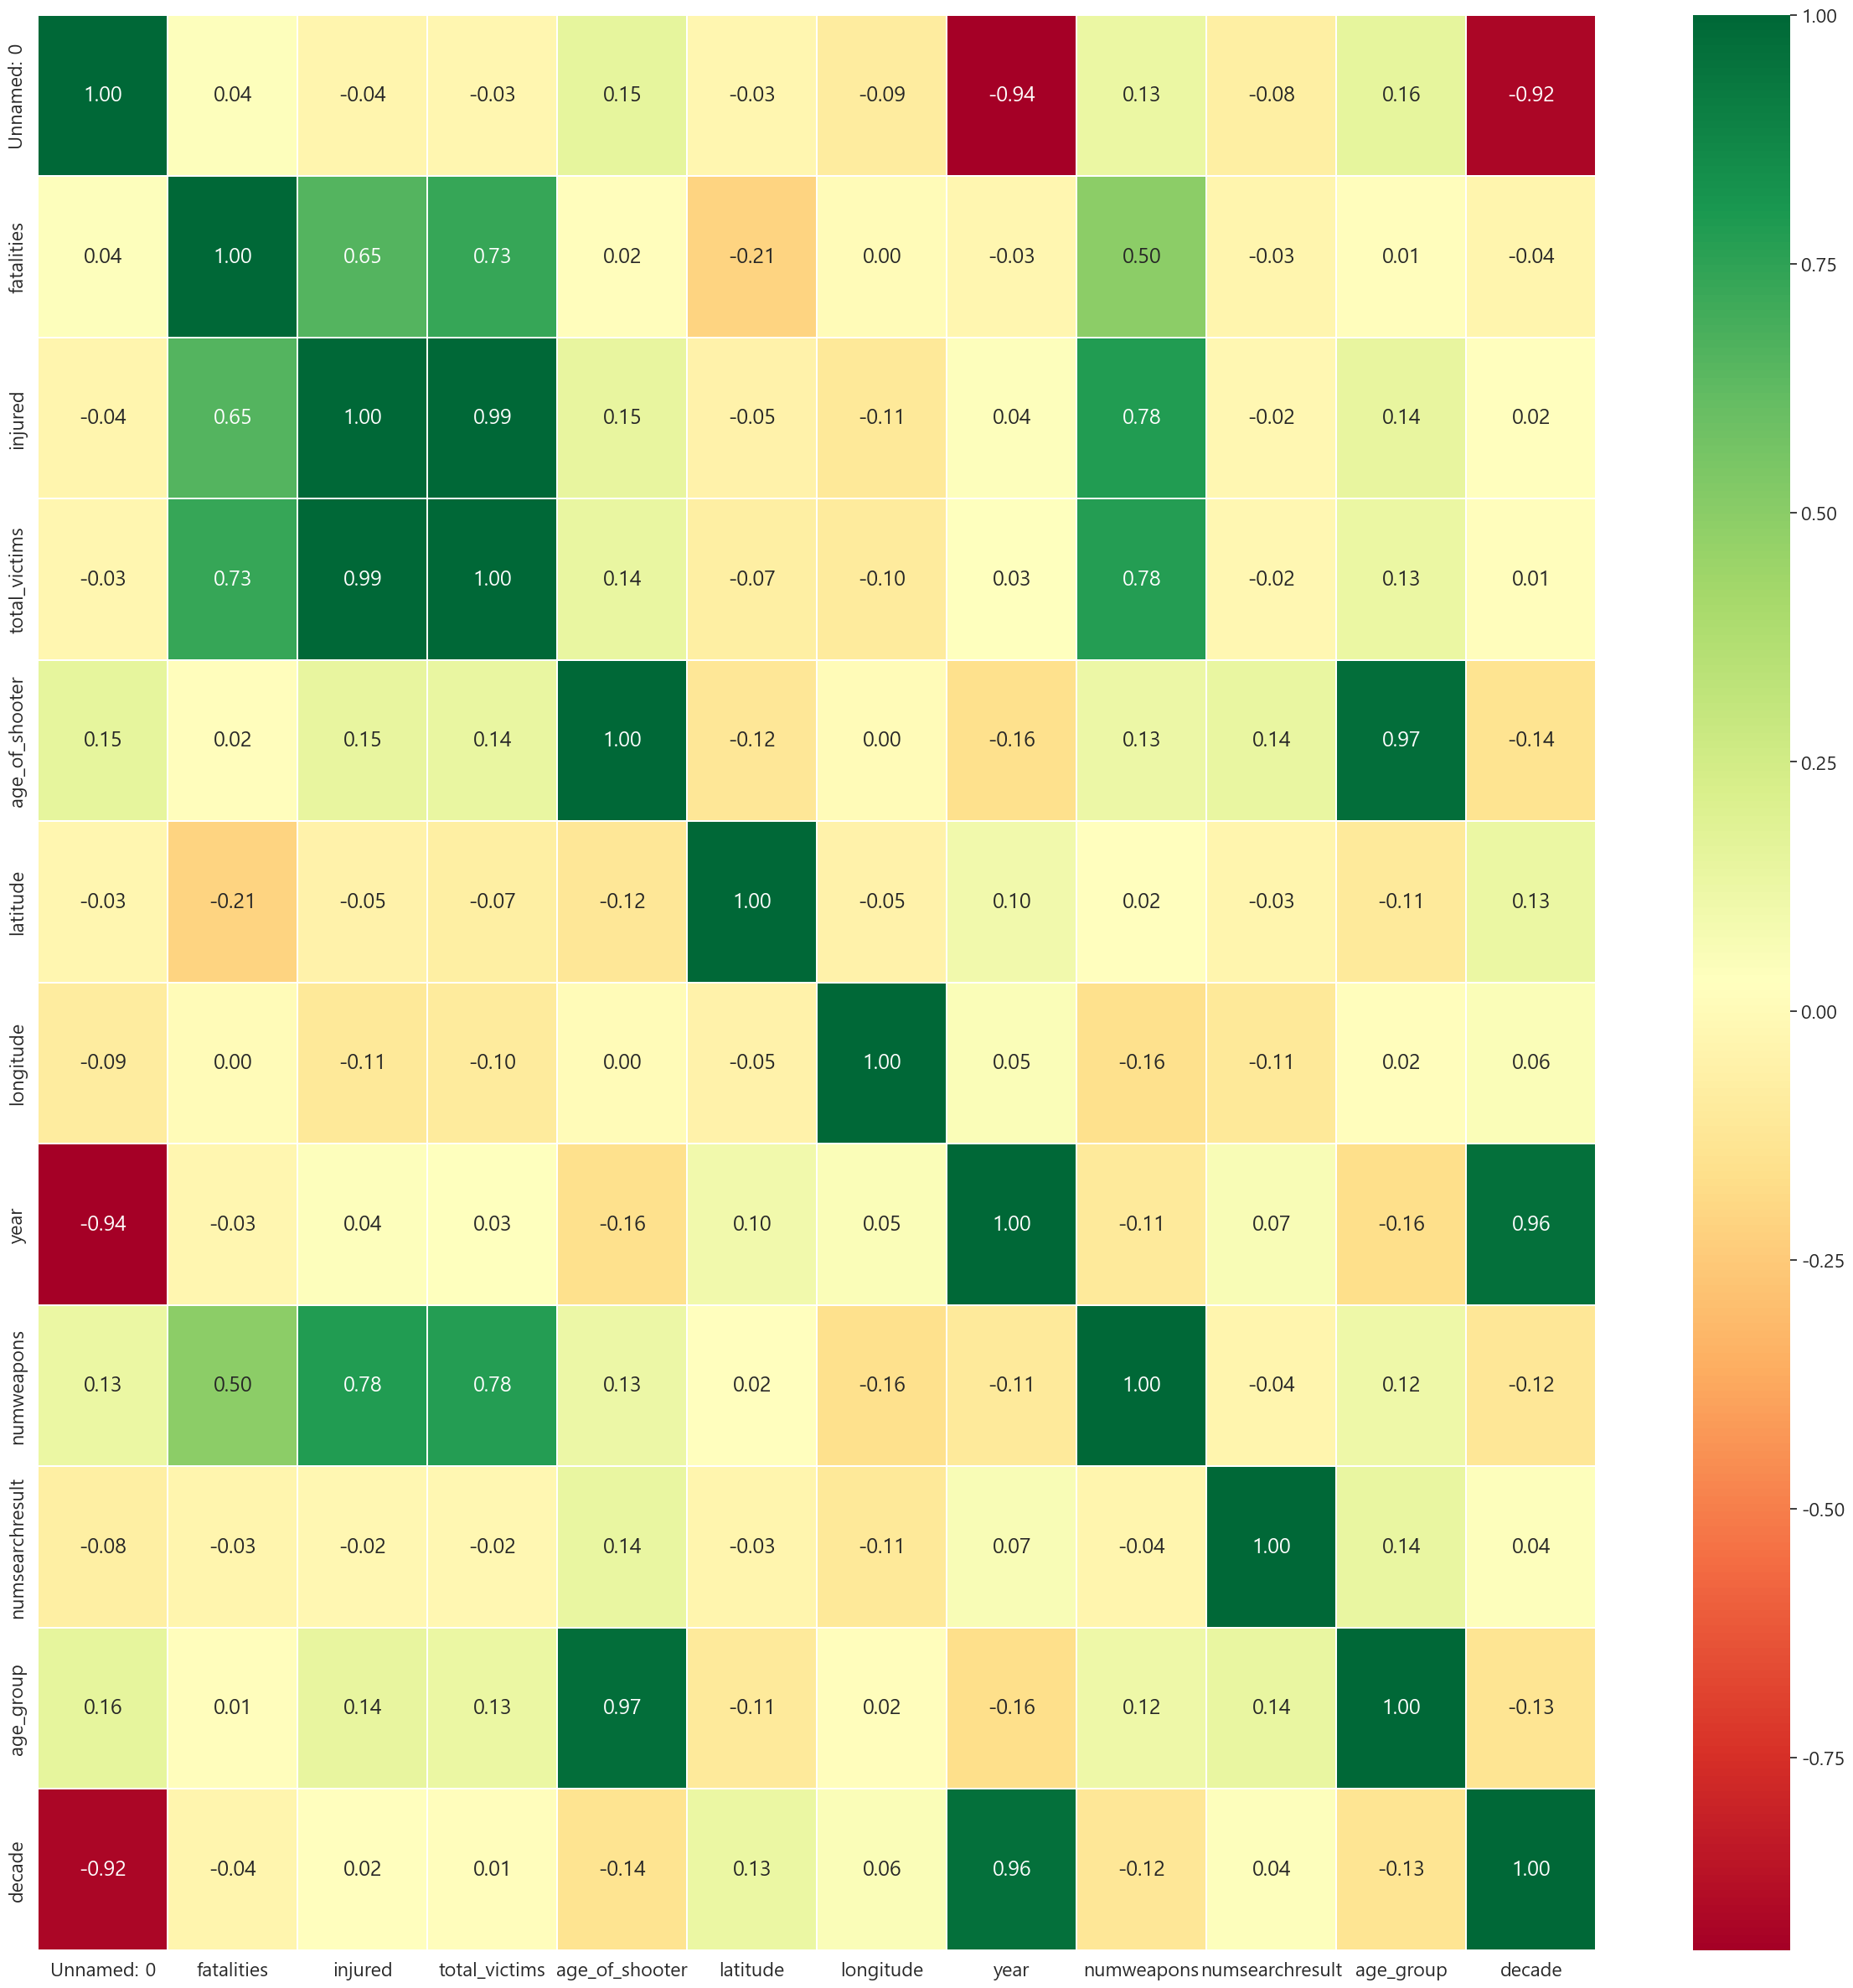

In [3]:
# 서로간의 상관관계를 나타내는 heatmap 1에 가까울수록 상관이 많다. 정확히 나오는진 모르겠음. 공부가 더 필요하다.
# 이걸 쓸거면 대충얼버무리는 걸로?

plt.subplots(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True, fmt='0.2f', cmap="RdYlGn", linewidths=0.2);

In [4]:
# year를 10년 주기로 분석하기 위해  decade 컬럼 추가
# 주별 총기규제 현황 확인하기 ( data, legal_df 사용)
# 주별 총기규제법에 대해 안전성 점수 집계 (총기에 대한 규제가 있을때 +1, 없을때 -1 부여)
# 해당 총 점수를 safety_score로 컬럼 추가
legal_df['firearmRegRequired'].fillna(0, inplace=True)
legal_df['permitReqToCarry'].fillna(0, inplace=True)
legal_df['permitReqToPurchase'].fillna(0, inplace=True)
legal_df['openCarryLegal'].fillna(1, inplace=True)

legal_df['firearmRegRequired'].replace('checked',1, inplace=True)
legal_df['permitReqToCarry'].replace('checked',1, inplace=True)
legal_df['permitReqToPurchase'].replace('checked',1, inplace=True)
legal_df['openCarryLegal'].replace('checked',0, inplace=True)

legal_df['safety_score']=legal_df.sum(axis=1)
state_safety = legal_df[['state','safety_score']].sort_values(by=['safety_score','state'], ascending=[False,True]).reset_index(drop=True)

C:\Users\user\AppData\Local\Temp\ipykernel_11512\2568566537.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  legal_df['safety_score']=legal_df.sum(axis=1)


In [5]:
# 기존 데이터에 safety_score를 추가하기


In [6]:
#전체적인 데이터
data_safety_merge = pd.merge(df, state_safety, on = 'state', how = 'inner')

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


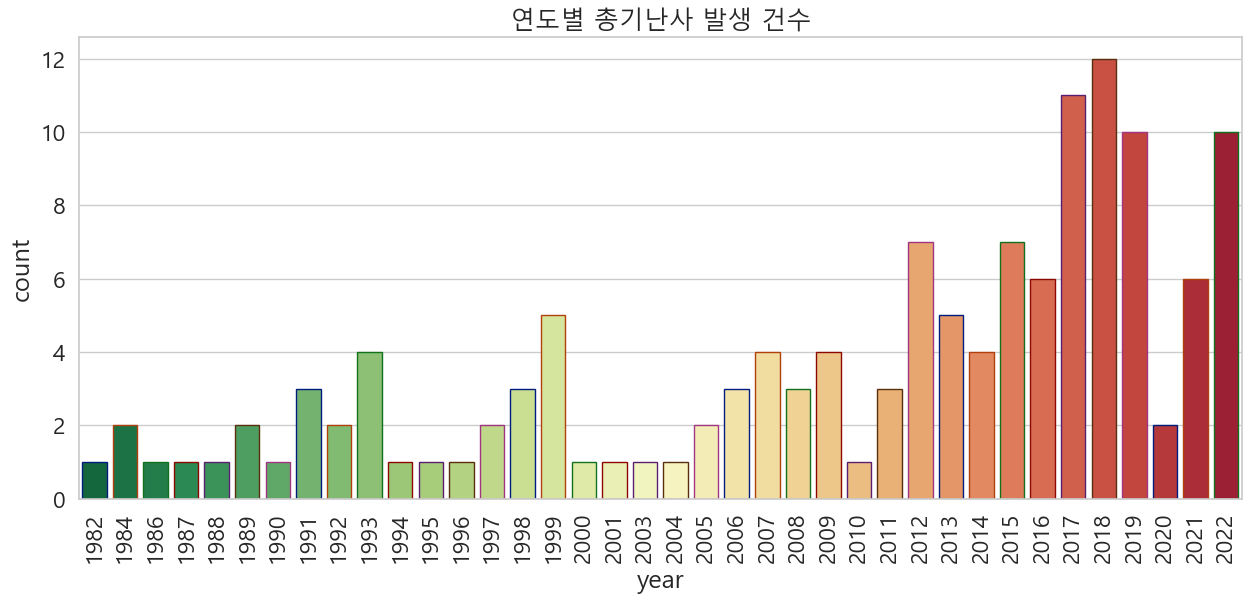

In [7]:
# 연도별 총기난사 발생 건수

plt.subplots(figsize=(15,6))
sns.countplot('year', data=df, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('연도별 총기난사 발생 건수')
plt.show()

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


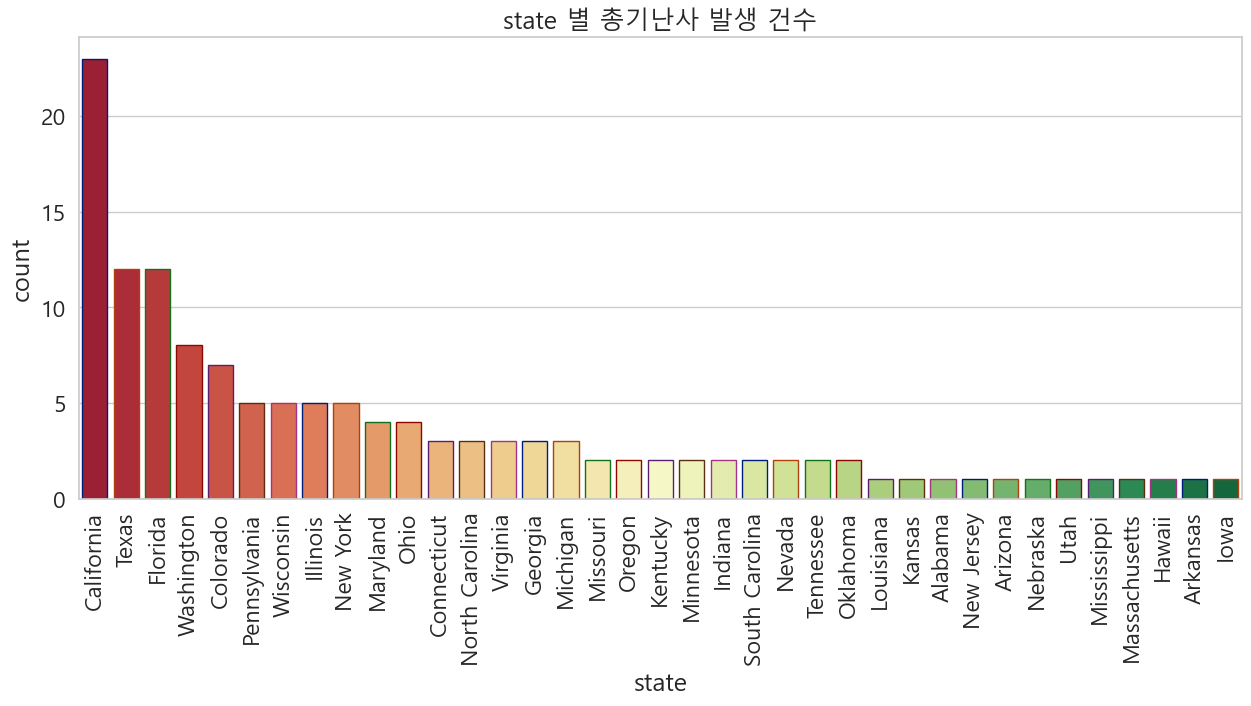

In [8]:
# state 별 총기난사 발생 건수

plt.subplots(figsize=(15,6))
sns.countplot('state', data=df, palette='RdYlGn',
              edgecolor=sns.color_palette('dark',7),
              order=df['state'].value_counts().index)
plt.xticks(rotation=90)
plt.title('state 별 총기난사 발생 건수')
plt.show()

In [9]:
state_population = pd.read_csv('data/NST-EST2021-alldata.csv')
state_population=state_population.drop(index=[0,1,2,3,4])

jsonfile = open('data/us-states.json','r',encoding='utf8').read()
jsondata = json.loads(jsonfile)
loc = [39.8333333,-98.585522]
m = folium.Map(loc,zoom_start=4)
folium.Choropleth(jsondata,
                  data=state_population,
                  columns=['NAME','POPESTIMATE2021'],
                  key_on='properties.name',bins=50,fill_color='BuPu').add_to(m)
mc = MarkerCluster().add_to(m)
for loc, lat, lng in zip(df['location'], df['latitude'], df['longitude']):
    folium.Marker([lat, lng], popup=loc, icon=folium.Icon(icon='bookmark', color='black')).add_to(mc)
m

In [10]:
# 피해자의 수를 기준으로 지도 시각화

ms = df.sort_values('total_victims', ascending=False)[:140]
# 피해자의 수가 많은 순으로 데이터 정렬
map2 = folium.Map(location=[30,0], tiles='CartoDB dark_matter' , zoom_start=2)
for _, row in ms[0:100].iterrows():
    if ~np.isnan(row['latitude']):
        folium.CircleMarker(location=[row['latitude'], row['longitude']],
                            radius=row['total_victims']/100, fill=True,
                            color='red', fill_opacity=0.7).add_to(map2)
map2

<function matplotlib.pyplot.show(close=None, block=None)>

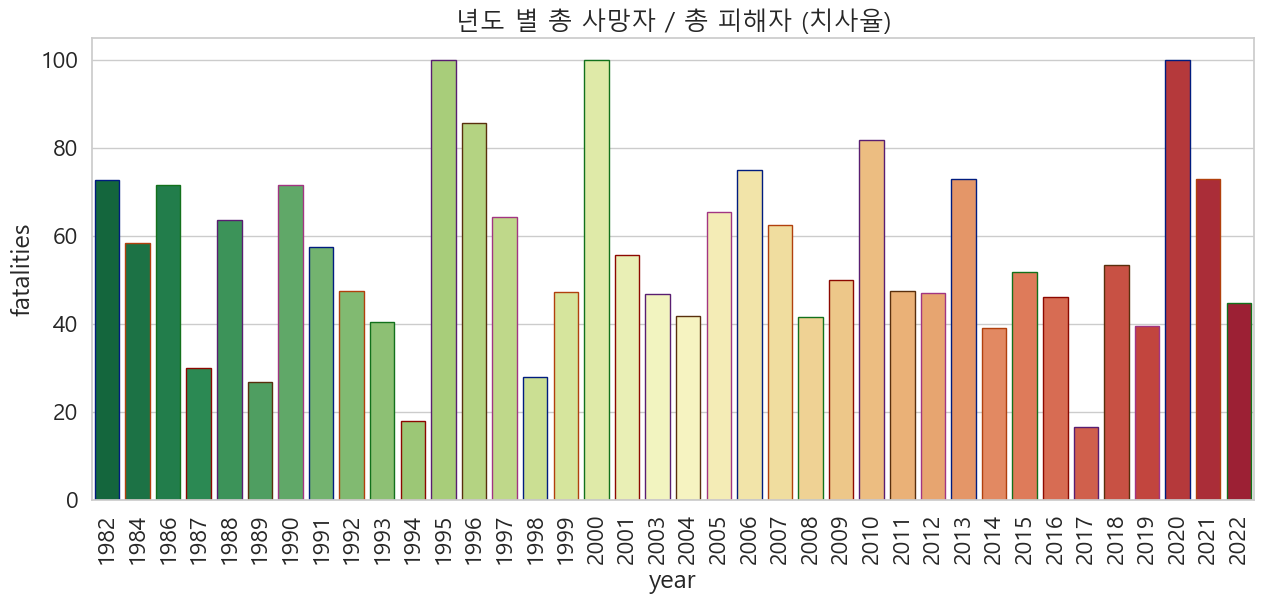

In [11]:
# 년도 별 총 사망자 / 년도 별 총 피해자 
data_n= df.groupby('year')['total_victims'].sum()
data = df.groupby('year')['fatalities'].sum()

for i in data.index :
    data[i] = data[i]/data_n[i]*100


plt.subplots(figsize=(15,6))   
sns.barplot(x=data.index, y=data ,palette='RdYlGn_r', edgecolor=sns.color_palette('dark',7))

plt.xticks(rotation=90)
plt.title('년도 별 총 사망자 / 총 피해자 (치사율)')
plt.show


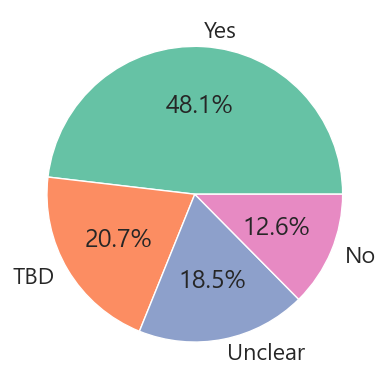

In [12]:
# 정신 이상 사건 파이그래프
data = df['prior_signs_mental_health_issues'].value_counts()
labels = df['prior_signs_mental_health_issues'].value_counts().index
plt.pie(data, labels=labels, autopct='%0.1f%%')
plt.show()

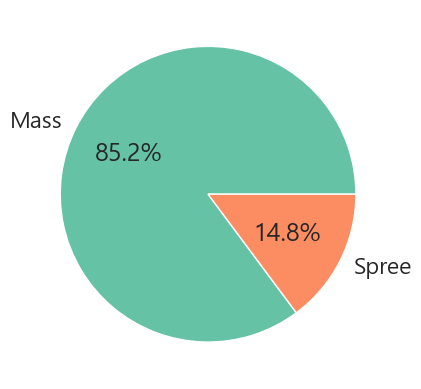

In [13]:
# 타입 별 사건 수 파이 그래프
# mass : 관련된 장소(건물의 여러 방 또는 블록의 여러 건물)로 이동하더라도 하나의 기본 위치에서 발생하는 집중적이고 단일한 행위입니다.
# spree : 여러 장소에서 최소 3건의 연쇄 살인을 포함합니다. 살인은 상당히 가까운 시간에 발생하지만 시간 프레임은 대량 살인자보다 훨씬 오래 지속되며 위치는 더 멀리 떨어져 있습니다.
data = df['type'].value_counts()
labels = df['type'].value_counts().index
plt.pie(data, labels=labels, autopct='%0.1f%%')
plt.show()

In [14]:
# total_victims 의 숫자만큼의 df2의 산점도 그래프 색상 크기

#전처리, 특이값 확인
#df3.groupby('case')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:10]

In [15]:
#전처리, 특이값 제거
df2 = pd.read_csv('data/df3.csv')
q = df2[df2['case'].str.contains('Las Vegas')].index
w = df2[df2['case'].str.contains('Orlando nightclub')].index
e = df2[df2['case'].str.contains('Aurora theater')].index
df2.drop(q, inplace=True)
df2.drop(w, inplace=True)
df2.drop(e, inplace=True)

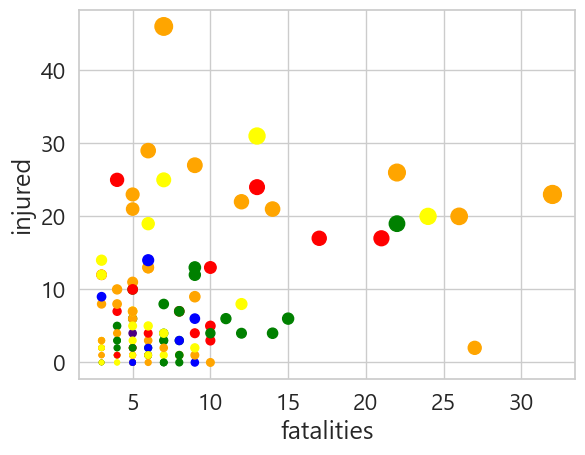

In [16]:
# 연령별 10~ 70 빨주노초파남보의 색이 뜨도록 하는 함수

mc = np.where(df2['age_group']==10, 'red', np.where(df2['age_group']==20, 'orange', np.where(df2['age_group']==30, 'yellow', np.where(df2['age_group']==40, 'Green', np.where(df2['age_group']==50, 'blue', np.where(df2['age_group']==60, 'Indigo', 'purple'))))))
# total_victims 의 숫자만큼의 df2의 산점도
df2.plot.scatter(x='fatalities', y='injured', c = mc, s=df2.total_victims*3);

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


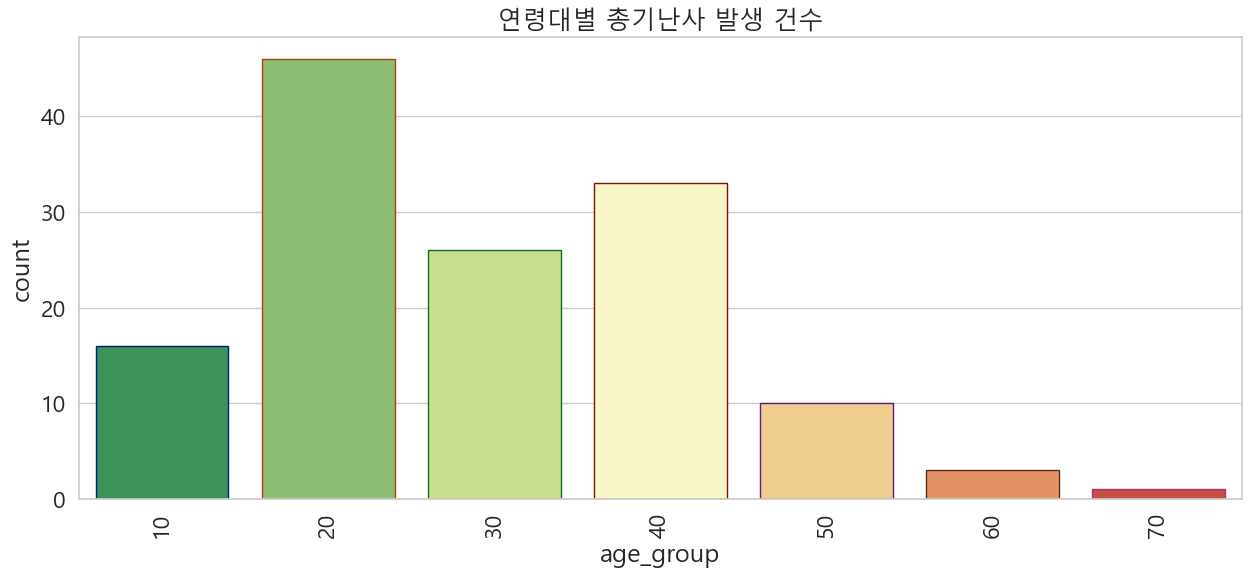

In [17]:
# 연령대별 총기난사 발생 건수

plt.subplots(figsize=(15,6))
sns.countplot('age_group', data=df, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('연령대별 총기난사 발생 건수')
plt.show()

In [18]:
## 인종 관련

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


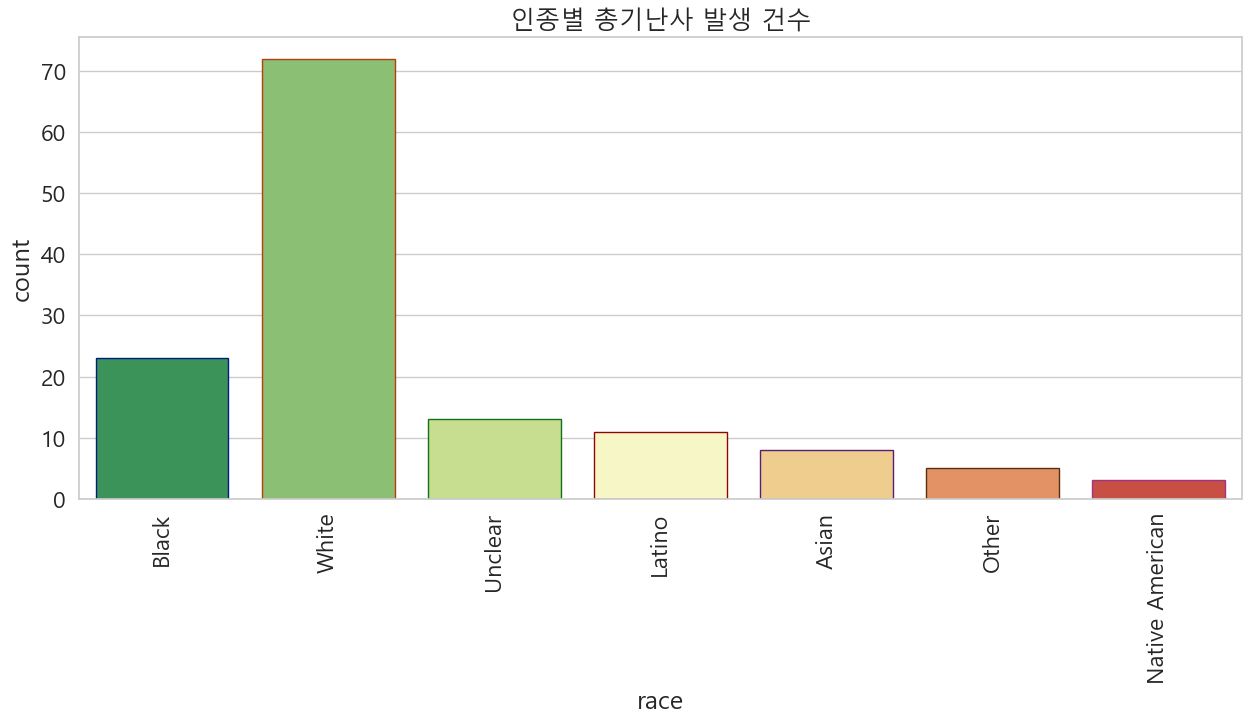

In [19]:
## 인종 관련
# 인종 별 총기난사 발생 건수

plt.subplots(figsize=(15,6))
sns.countplot('race', data=df, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('인종별 총기난사 발생 건수')
plt.show()

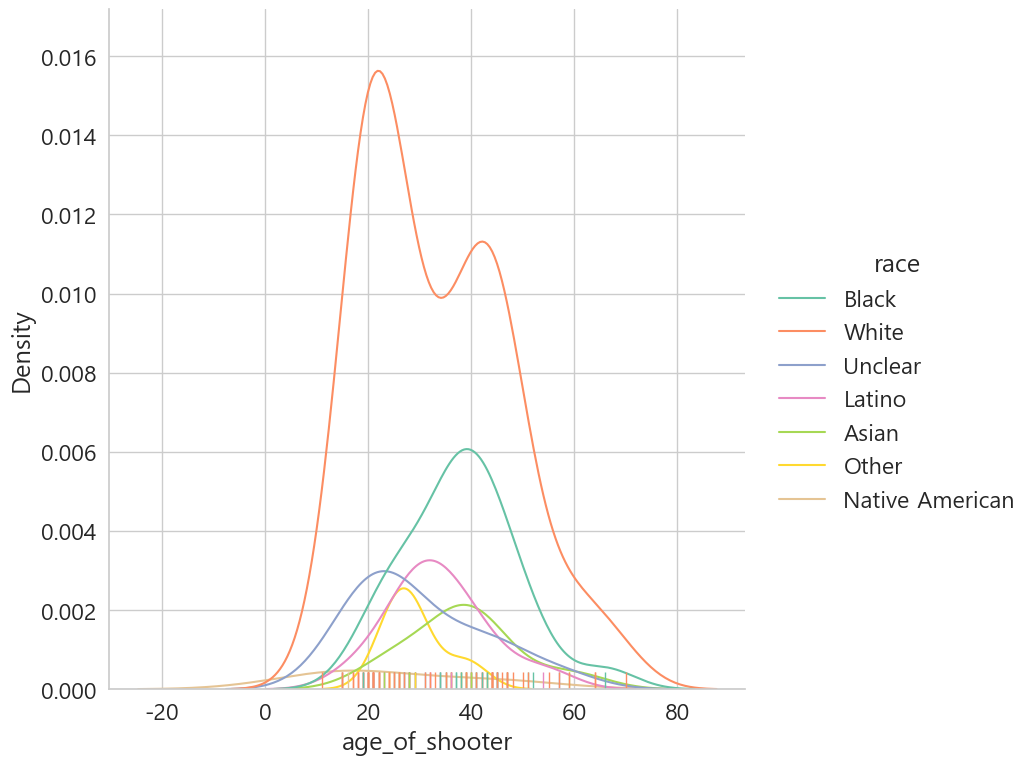

In [20]:
# 연령대 별로 인종별로 수치 확인

sns.displot(x='age_of_shooter', hue='race', kind='kde', rug=True, height = 8, data=df);

Text(0.5, 0, '나이')

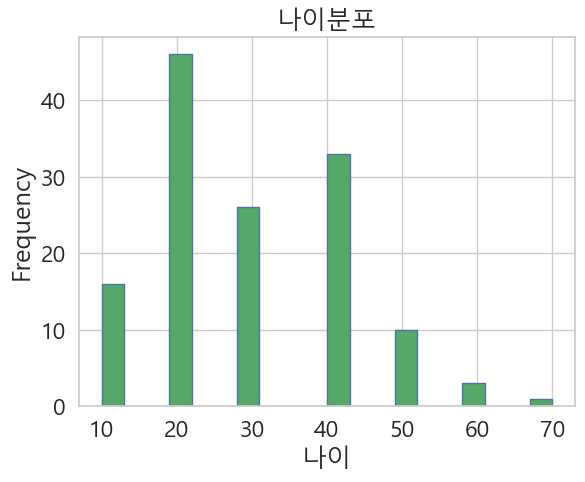

In [21]:
# age_group 분포 막대 그래프
df['age_group'].plot.hist(bins=20, edgecolor='b', color='g')
plt.title('나이분포')
plt.xlabel('나이')

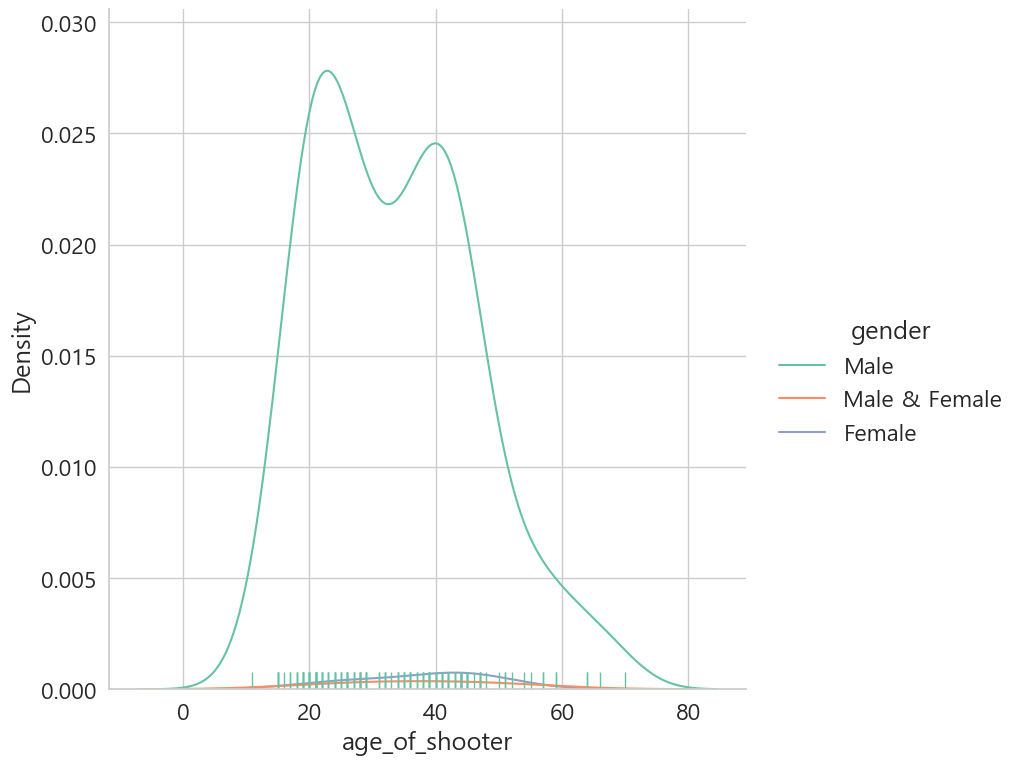

In [22]:
# 연령대 별로 성별별로 수치 확인

sns.displot(x='age_of_shooter', hue='gender', kind='kde', rug=True, height = 8, data=df);

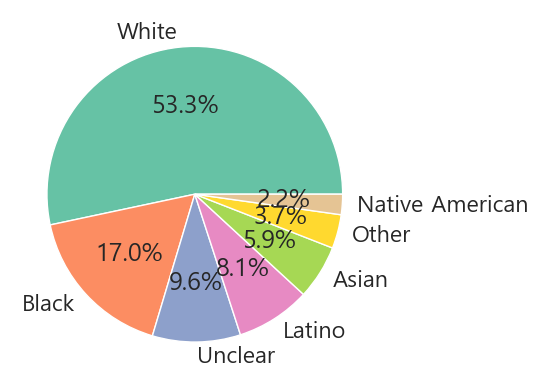

In [23]:
# 인종 별 사건 파이그래프
data = df['race'].value_counts()
labels = df['race'].value_counts().index
plt.pie(data, labels=labels, autopct='%0.1f%%')
plt.show()

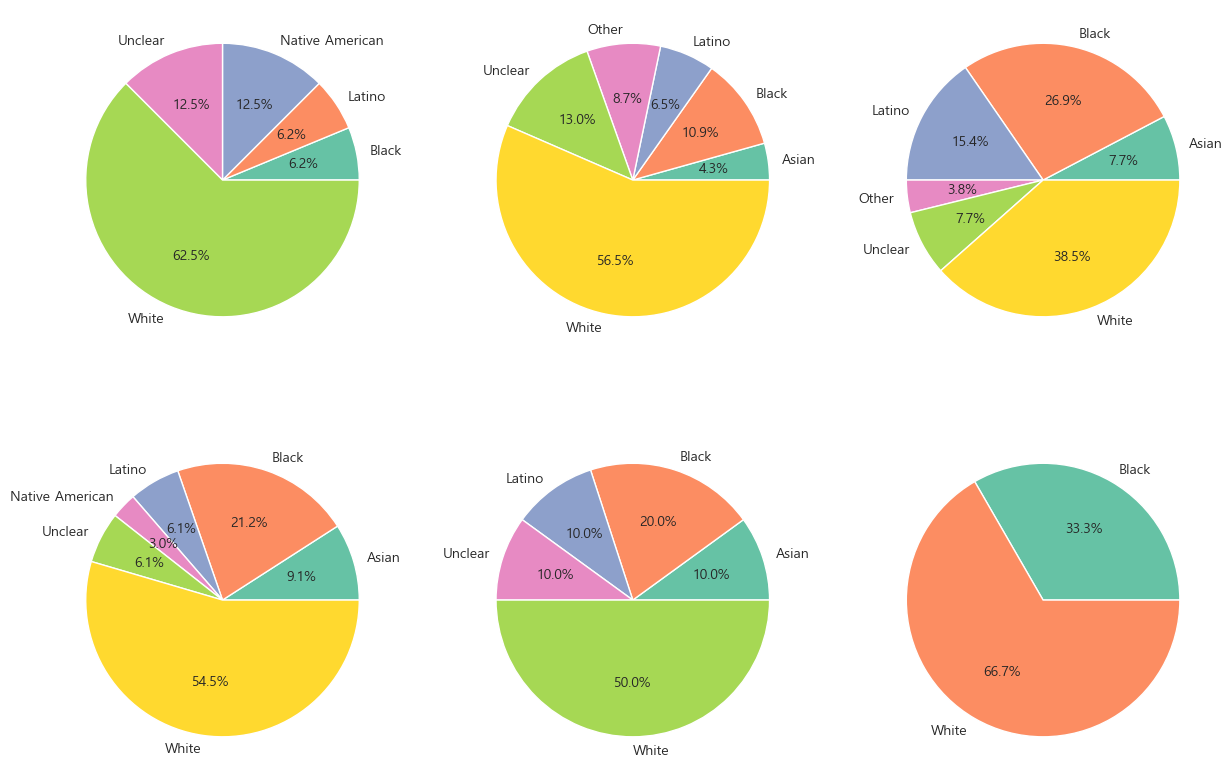

In [24]:
age_race = df.groupby(['age_group','race'])['case'].count().reset_index()
age_race = age_race.sort_values(['age_group','race'])
age_race.head(2)
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.pie(age_race[age_race['age_group']==10]['case'], labels= age_race[age_race['age_group']==10]['race'], autopct= '%.1f%%',textprops={'size': 10})

plt.subplot(2,3,2)
plt.pie(age_race[age_race['age_group']==20]['case'], labels= age_race[age_race['age_group']==20]['race'], autopct= '%.1f%%',textprops={'size': 10})

plt.subplot(2,3,3)
plt.pie(age_race[age_race['age_group']==30]['case'], labels= age_race[age_race['age_group']==30]['race'], autopct= '%.1f%%',textprops={'size': 10})

plt.subplot(2,3,4)
plt.pie(age_race[age_race['age_group']==40]['case'], labels= age_race[age_race['age_group']==40]['race'], autopct= '%.1f%%',textprops={'size': 10})

plt.subplot(2,3,5)
plt.pie(age_race[age_race['age_group']==50]['case'], labels= age_race[age_race['age_group']==50]['race'], autopct= '%.1f%%',textprops={'size': 10})

plt.subplot(2,3,6)
plt.pie(age_race[age_race['age_group']==60]['case'], labels= age_race[age_race['age_group']==60]['race'], autopct= '%.1f%%',textprops={'size': 10})
plt.show()

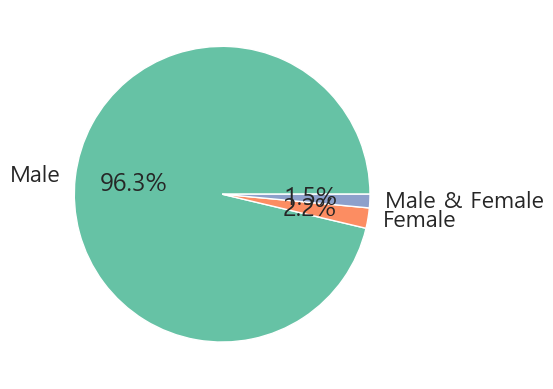

In [25]:
# 성별 사건 파이그래프 발생 남성 많음
data = df['gender'].value_counts()
labels = df['gender'].value_counts().index
plt.pie(data, labels=labels, autopct='%0.1f%%')
plt.show()
# 대다수의 범인이 남성.

In [26]:
space_victims_mean = df.groupby(['location.1'])[['total_victims']].mean().sort_values('total_victims',ascending=False)

Text(0.5, 1.0, '현장별 피해자 수(평균)')

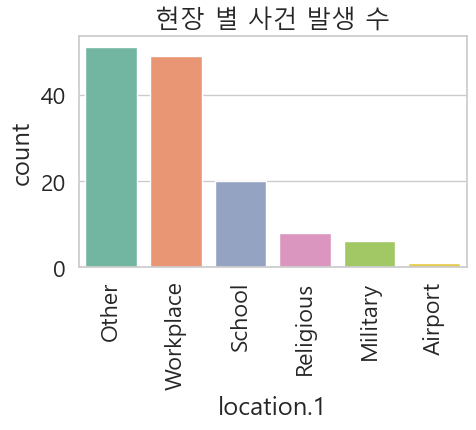

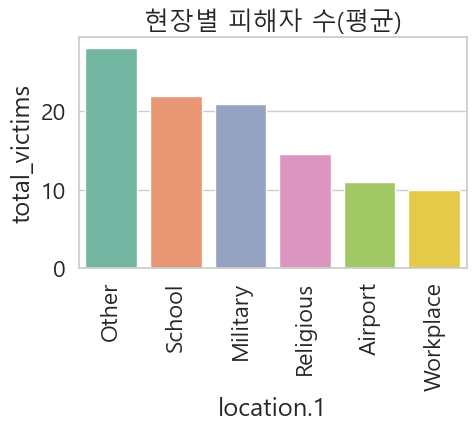

In [27]:
# 현장별 사건 발생 수
ax = plt.subplots(figsize=(5,3))
ax = sns.countplot(x=df["location.1"], order = df['location.1'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('현장 별 사건 발생 수')

# 현장별 피해자 수(평균)
ax2 = plt.subplots(figsize=(5,3))
ax2 = sns.barplot(data=space_victims_mean, x=space_victims_mean.index, y='total_victims')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_title('현장별 피해자 수(평균)')

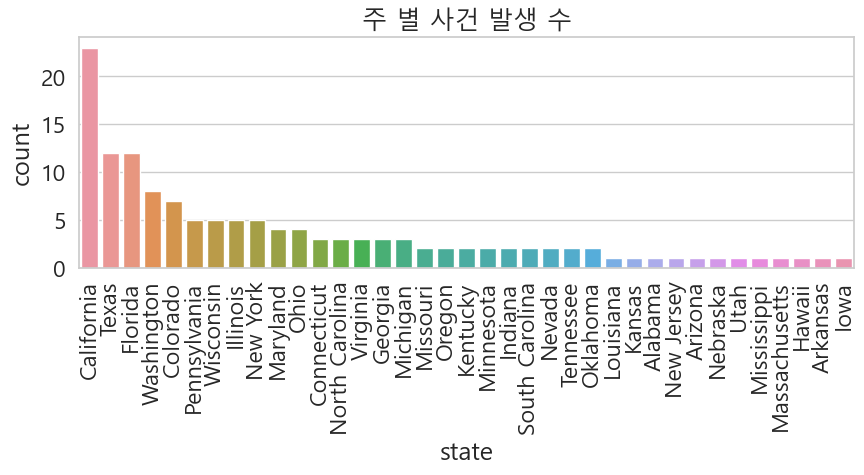

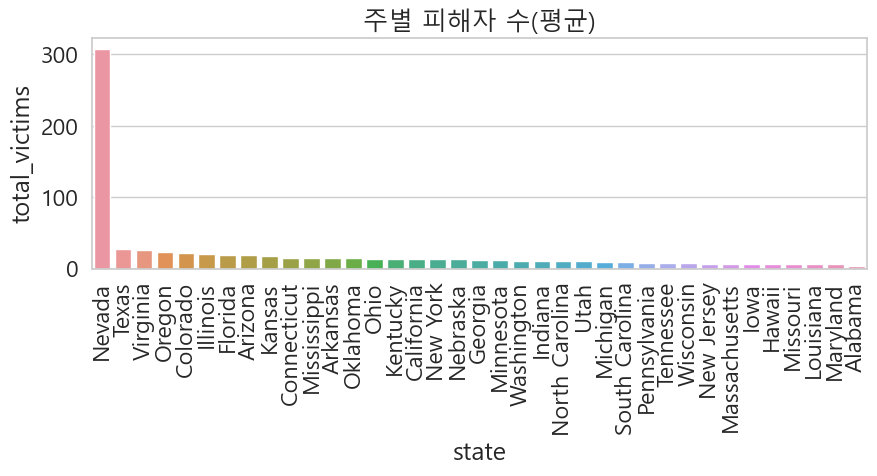

In [28]:
# 주별 사건 피해자(사망자+부상자) 합계 및 평균 확인하기
state_victims_sum = df.groupby(['state'])[['total_victims']].sum().sort_values('total_victims',ascending=False)
state_victims_mean = df.groupby(['state'])[['total_victims']].mean().sort_values('total_victims',ascending=False)
# 주별 사건 발생 수
ax = plt.subplots(figsize=(10,3))
ax = sns.countplot(x=df["state"], order = df['state'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('주 별 사건 발생 수')

# 주별 피해자 수(평균)
ax2 = plt.subplots(figsize=(10,3))
ax2 = sns.barplot(data=state_victims_mean, x=state_victims_mean.index, y='total_victims')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation = 90)
ax2.set_title('주별 피해자 수(평균)')


# # 주별 피해자 수(합계)
# ax1 = plt.subplots(figsize=(10,3))
# ax1 = sns.barplot(data=state_victims_sum, x=state_victims_sum.index, y='total_victims')
# ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
# ax1.set_title('주별 피해자 수(합계)')

plt.show()

<AxesSubplot:xlabel='prior_signs_mental_health_issues'>

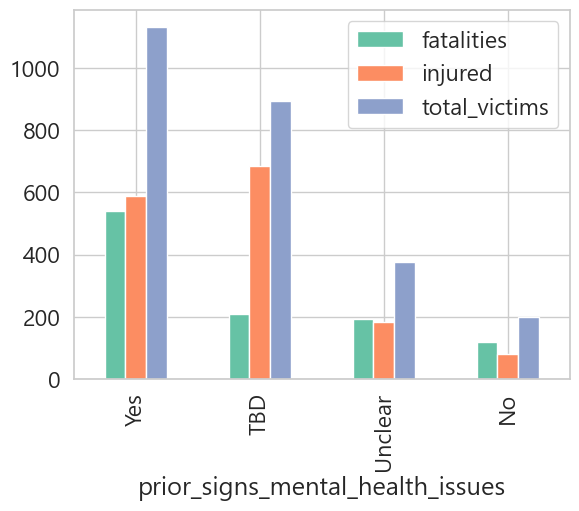

In [29]:
# 정신질환 여부에 따른 희생자수 합계
mental_victims_sum = df.groupby('prior_signs_mental_health_issues')[['fatalities','injured','total_victims']].sum().sort_values('total_victims',ascending=False)
mental_victims_sum.plot.bar()

<AxesSubplot:xlabel='prior_signs_mental_health_issues'>

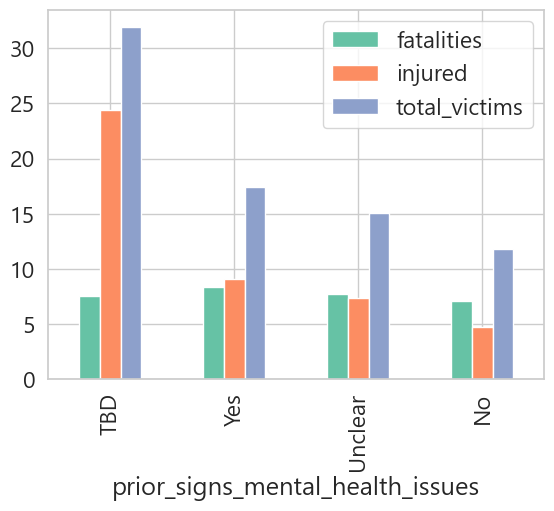

In [30]:
# 정신질환 여부에 따른 희생자수 평균
mental_victims_mean = df.groupby('prior_signs_mental_health_issues')[['fatalities','injured','total_victims']].mean().sort_values('total_victims',ascending=False)
mental_victims_mean.plot.bar()

In [31]:
#top of top
# state 별 부상자, 사상자, 총피해자 top5
# state를 기준으로 'fatalities', 'injured', 'total_victims' 값들을 더하고 높은 순으로 정렬해서 5가지만 뽑아낸다 (top5)


# df1 = df.groupby('state')['fatalities', 'injured', 'total_victims'].sum().reset_index().sort_values('total_victims', ascending=False)[:5]

C:\Users\user\AppData\Local\Temp\ipykernel_11512\4190052072.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby('state')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:5]


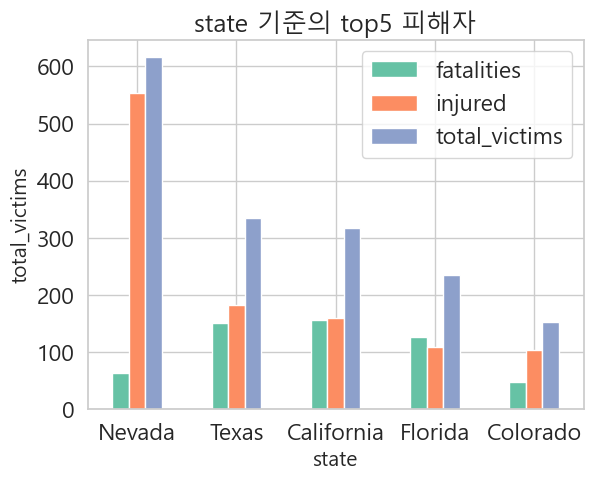

In [32]:
# state 별 부상자, 사상자, 총피해자 top5
df1 = df.groupby('state')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:5]
df1.plot.bar()
plt.title('state 기준의 top5 피해자', fontsize=18)
plt.xlabel('state', fontsize=15)
plt.ylabel('total_victims', fontsize=15)
plt.xticks(rotation=0);
plt.yticks(rotation=0);

C:\Users\user\AppData\Local\Temp\ipykernel_11512\3568698285.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby('year')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:5]


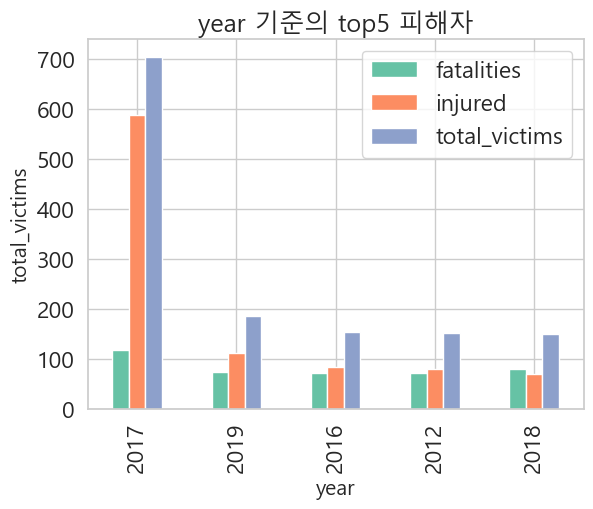

In [33]:
df1 = df.groupby('year')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:5]
df1.plot.bar()
plt.title('year 기준의 top5 피해자', fontsize=18)
plt.xlabel('year', fontsize=15)
plt.ylabel('total_victims', fontsize=15)
plt.xticks(rotation=90);
plt.yticks(rotation=0);

C:\Users\user\AppData\Local\Temp\ipykernel_11512\283373485.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby('race')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:5]


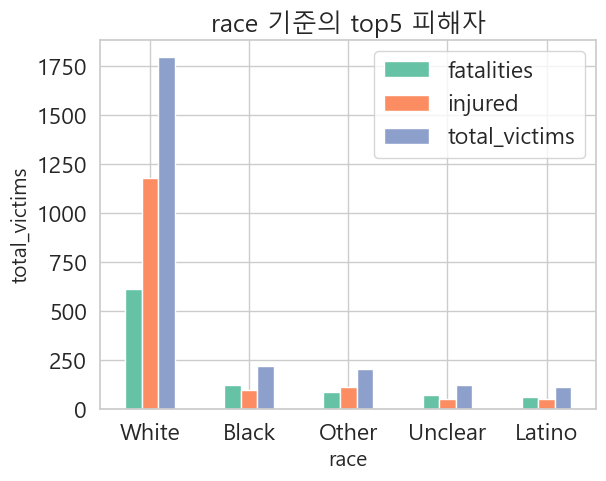

In [34]:
df1 = df.groupby('race')['fatalities', 'injured', 'total_victims'].sum().sort_values('total_victims', ascending=False)[:5]
df1.plot.bar()
plt.title('race 기준의 top5 피해자', fontsize=18)
plt.xlabel('race', fontsize=15)
plt.ylabel('total_victims', fontsize=15)
plt.xticks(rotation=0);
plt.yticks(rotation=0);

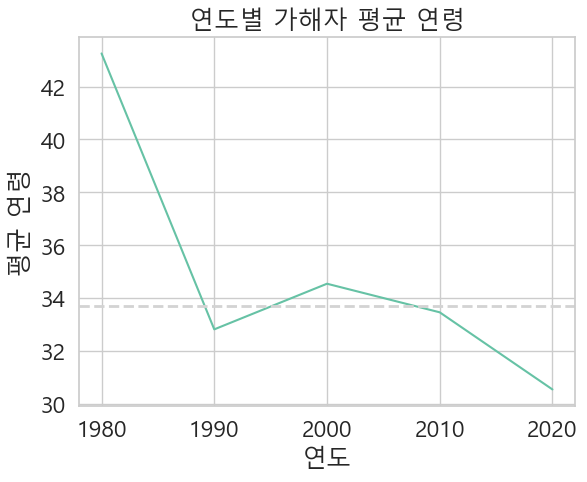

In [35]:
# 10년 기준 연도별 가해자 평균 연령 시각화
# 총기난사 사건의 발생년도를 10년주기로 구분하여 통계치 구함.  
# 1980년대를 시작으로 2020년대에 이르기까지 점차 가해자의 평균 연령이 줄어들고 있음을 확인할 수 있다.
total_age_mean = df['age_of_shooter'].mean()
decade_age_mean = df.groupby('decade')['age_of_shooter'].mean()

plt.plot(decade_age_mean)
plt.title('연도별 가해자 평균 연령')
plt.xlabel('연도')
plt.ylabel('평균 연령')
plt.axhline(total_age_mean, color='lightgray', linestyle='--', linewidth=2) # 수평선 : 전체 평균연령
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11512\3217213347.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df2.groupby('age_group')['fatalities', 'injured', 'total_victims'].sum().reset_index().sort_values('age_group')


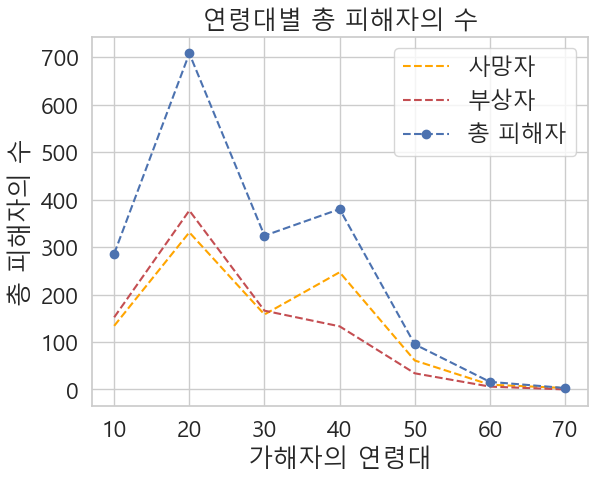

In [36]:
#전처리, 특이값 제거
df1 = df2.groupby('age_group')['fatalities', 'injured', 'total_victims'].sum().reset_index().sort_values('age_group')
age10 = df1[df1['age_group']==10]
age20 = df1[df1['age_group']==20]
age30 = df1[df1['age_group']==30]
age40 = df1[df1['age_group']==40]
age50 = df1[df1['age_group']==50]
age60 = df1[df1['age_group']==60]
age70 = df1[df1['age_group']==70]
fig, ax =plt.subplots() 
ax.plot(df1['age_group'], df1['fatalities'], label='사망자', linestyle='--', color ='Orange')
ax.plot(df1['age_group'], df1['injured'], label='부상자', linestyle='--', color ='r')
ax.plot(df1['age_group'], df1['total_victims'], label='총 피해자', marker='o', linestyle='--', color='b')
ax.set_xlabel('가해자의 연령대')
ax.set_ylabel('총 피해자의 수')
ax.set_title('연령대별 총 피해자의 수')
plt.legend()

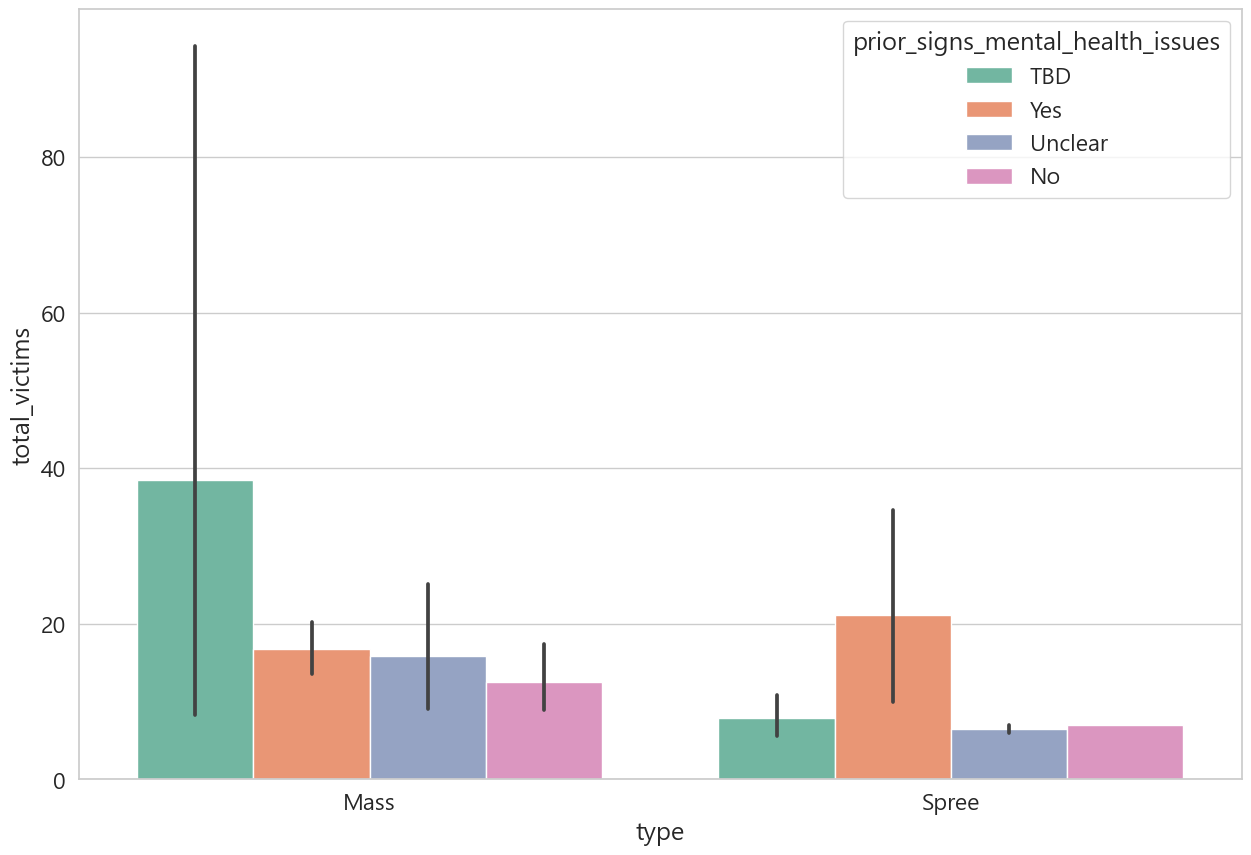

In [37]:
plt.figure(figsize=(15,10))
sns.barplot(x='type', y='total_victims', hue='prior_signs_mental_health_issues', data=df);

# TBD = 미정
# Unclear = 확실하지 않음

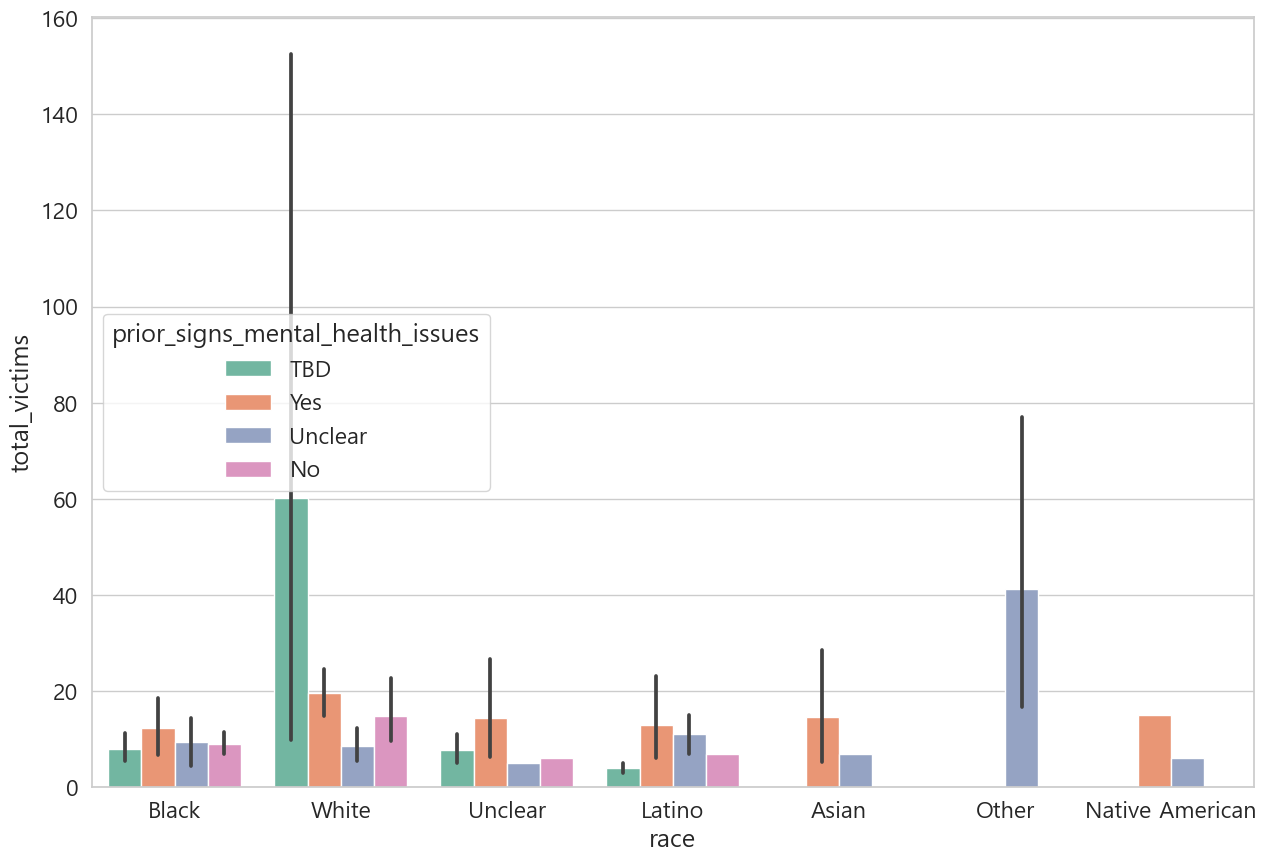

In [38]:
plt.figure(figsize=(15,10))
sns.barplot(x='race', y='total_victims', hue='prior_signs_mental_health_issues', data=df);

# TBD = 미정
# Unclear = 확실하지 않음

In [39]:
# 검색 결과 수 컬럼

<function matplotlib.pyplot.show(close=None, block=None)>

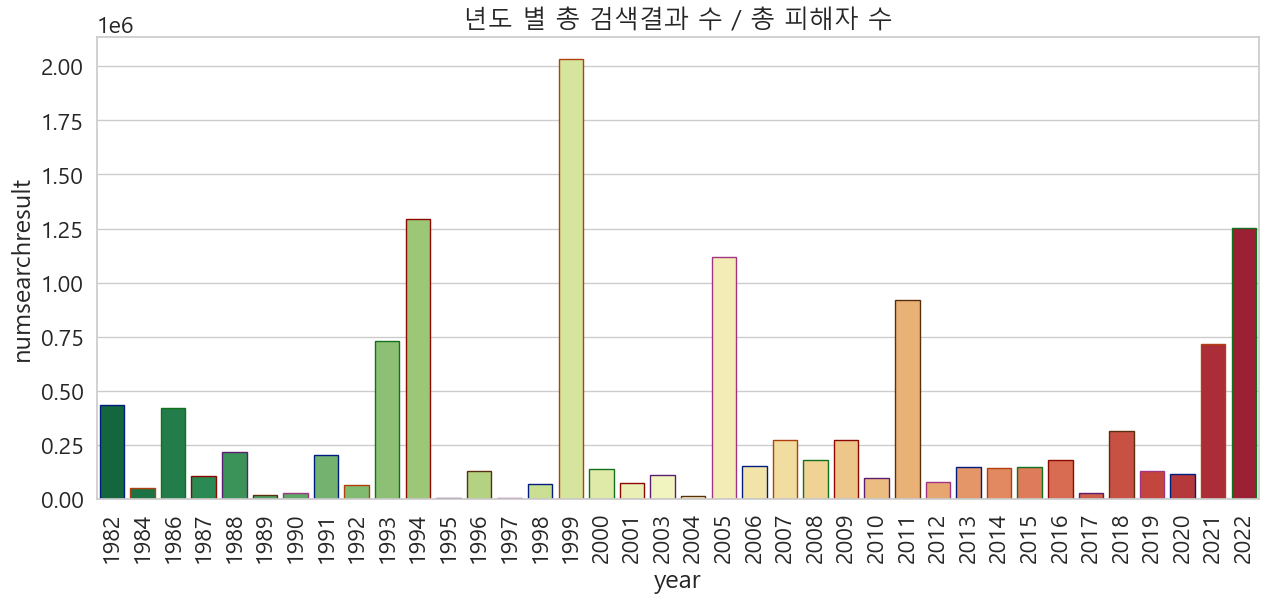

In [40]:
# 년도 별 총 검색결과 수 / 년도 별 총 피해자 수 
datadf= pd.read_csv('data/df3.csv')
datadf = datadf.drop(index=32)
data= datadf.groupby(['year'])['numsearchresult'].sum()
data_victim = datadf.groupby(['year'])['total_victims'].sum()

for i in data.index :
    data[i] = data[i]/data_victim[i]

    
plt.subplots(figsize=(15,6))    
sns.barplot(x=data.index, y=data ,palette='RdYlGn_r', edgecolor=sns.color_palette('dark',7))

plt.xticks(rotation=90)
plt.title(' 년도 별 총 검색결과 수 / 총 피해자 수 ')
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

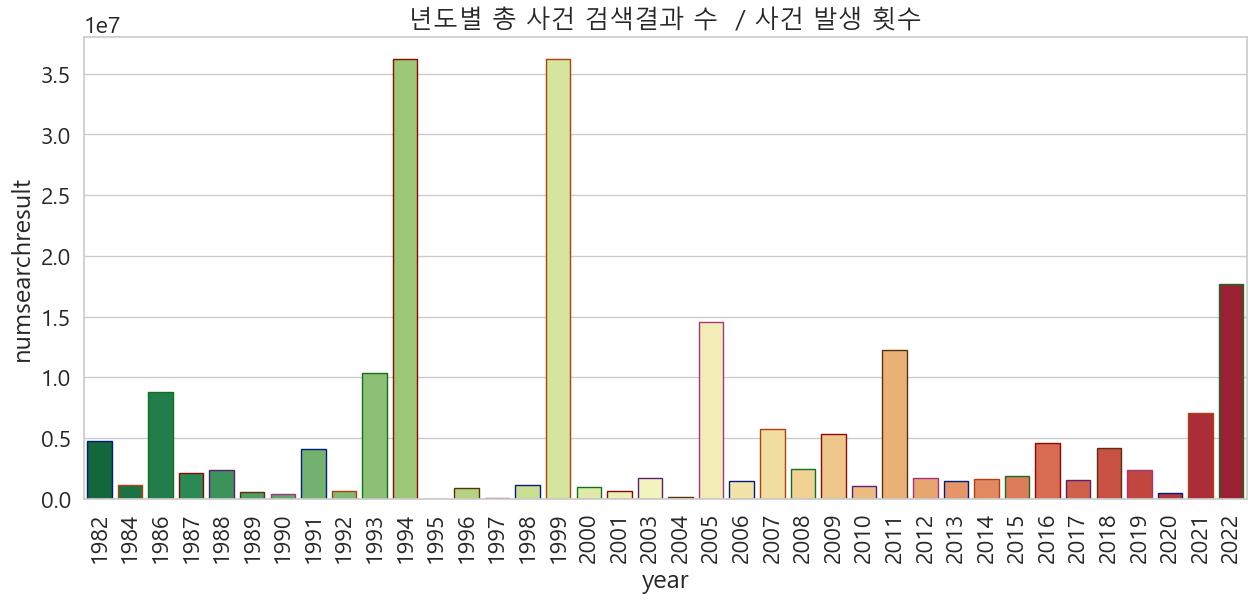

In [41]:
# 년도 별 총 검색결과 수 / 년도 별 사건 발생 횟수 

data= datadf.groupby(['year'])['numsearchresult'].sum()
data_n = datadf.groupby(['year'])['case'].count()

for i in data.index :
    data[i] = data[i]/data_n[i]


plt.subplots(figsize=(15,6))
    
sns.barplot(x=data.index, y=data ,palette='RdYlGn_r', edgecolor=sns.color_palette('dark',7))

plt.xticks(rotation=90)
plt.title('년도별 총 사건 검색결과 수  / 사건 발생 횟수')
plt.show

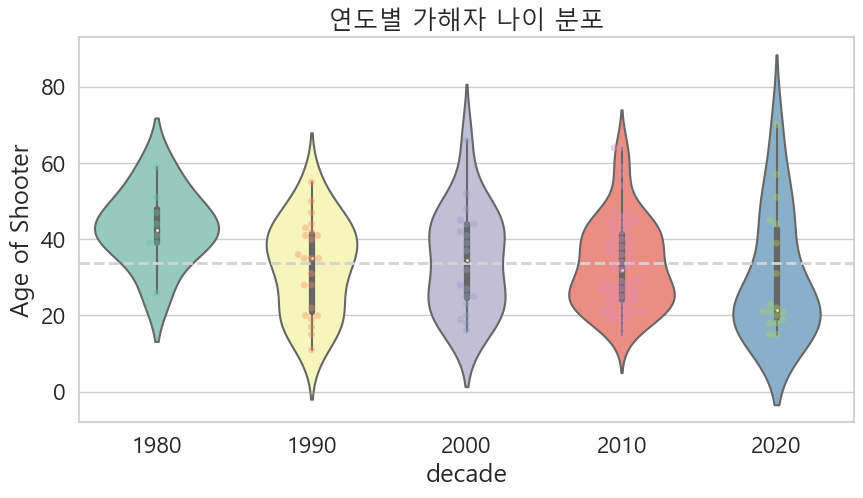

In [42]:
# 10년주기 연도별 가해자 연령 분포를 세분화 하여 시각화
# 바이올린 플롯을 활용하여 사건별 가해자 나이의 연도별 분포를 확인하였다.  
# 시간이 지날수록 가해자 연령 분포 밀집구간이 가해자 전체 평균 연령인 33~34세보다 낮은 곳에 나타남을 확인할 수 있다.

plt.figure(figsize=(10,5))
sns.violinplot(data = df, x = 'decade', y ='age_of_shooter', palette='Set3')
sns.swarmplot(data = df,x = 'decade', y ='age_of_shooter', alpha=0.4)
plt.axhline(total_age_mean, color='lightgray', linestyle='--', linewidth=2) # 수평선 : 전체 평균연령
plt.title('연도별 가해자 나이 분포')
plt.xlabel('decade')
plt.ylabel('Age of Shooter')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11512\1321242614.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['state'], rotation=90)


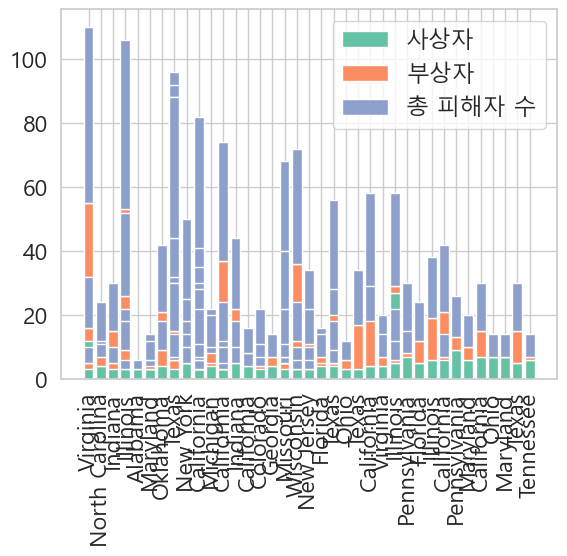

In [43]:
fig, ax = plt.subplots()
ax.bar(df2['state'], df2['fatalities'], label ='사상자')
ax.bar(df2['state'], df2['injured'], bottom=df2['fatalities'], label='부상자')
ax.bar(df2['state'], df2['total_victims'], bottom=df2['fatalities']+df2['injured'], label='총 피해자 수')

ax.set_xticklabels(df['state'], rotation=90)
ax.legend();

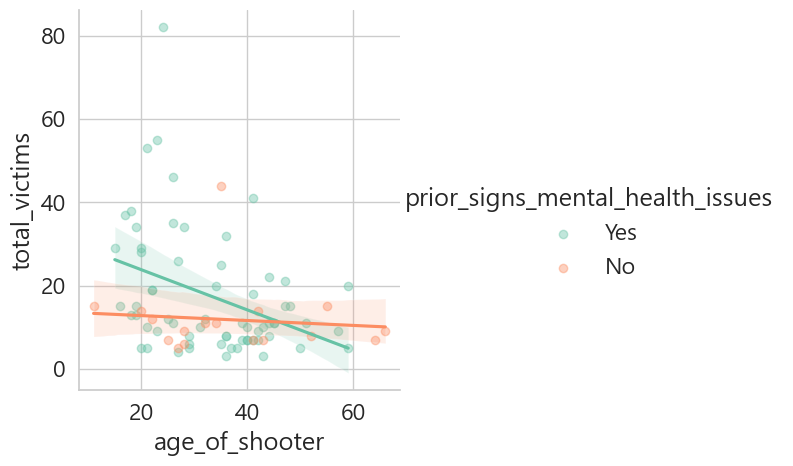

In [44]:

# 연령별 가해자의 정신질환 유무(yes, no)에 따른 상관관계 확인
# 저연령 정신이상 피해자수 많다.
mental_space = df2.groupby(['prior_signs_mental_health_issues','location.1'])[['total_victims','suicided']].sum()

mental_space.reset_index(inplace=True)

men_spa_yes = mental_space[mental_space['prior_signs_mental_health_issues']=='Yes']
men_spa_no = mental_space[mental_space['prior_signs_mental_health_issues']=='No']

mental_yes_no = data_safety_merge.drop(data_safety_merge[data_safety_merge['prior_signs_mental_health_issues']=='TBD'].index)
mental_yes_no = mental_yes_no.drop(mental_yes_no[mental_yes_no['prior_signs_mental_health_issues']=='Unclear'].index)
sns.lmplot(data=mental_yes_no, x="age_of_shooter", y="total_victims", hue="prior_signs_mental_health_issues",scatter_kws={'alpha':0.4} )
# plt.ylim(-5, 110)


In [45]:
df2['prior_signs_mental_health_issues']

0          TBD
1          TBD
2          TBD
3          Yes
4          TBD
        ...   
130        Yes
131    Unclear
132        Yes
133        Yes
134        Yes
Name: prior_signs_mental_health_issues, Length: 132, dtype: object

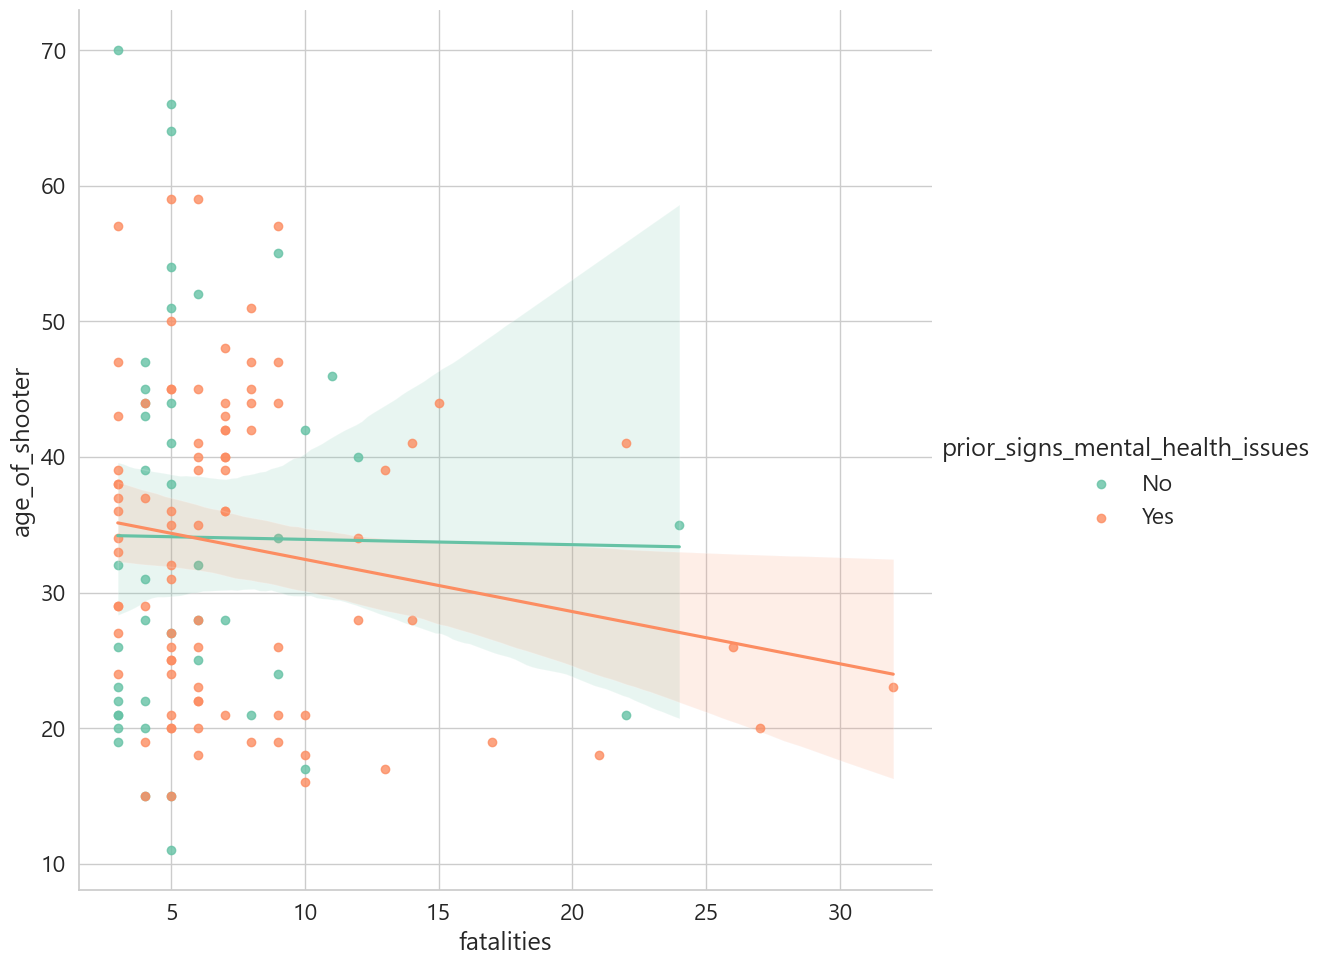

In [46]:

df2.loc[(df2['prior_signs_mental_health_issues'] == 'TBD'), 'prior_signs_mental_health_issues'] = 'No'
df2.loc[(df2['prior_signs_mental_health_issues'] == 'Unclear'), 'prior_signs_mental_health_issues'] = 'Yes'
sns.lmplot(x='fatalities', y='age_of_shooter', hue='prior_signs_mental_health_issues', height=10, data=df2)


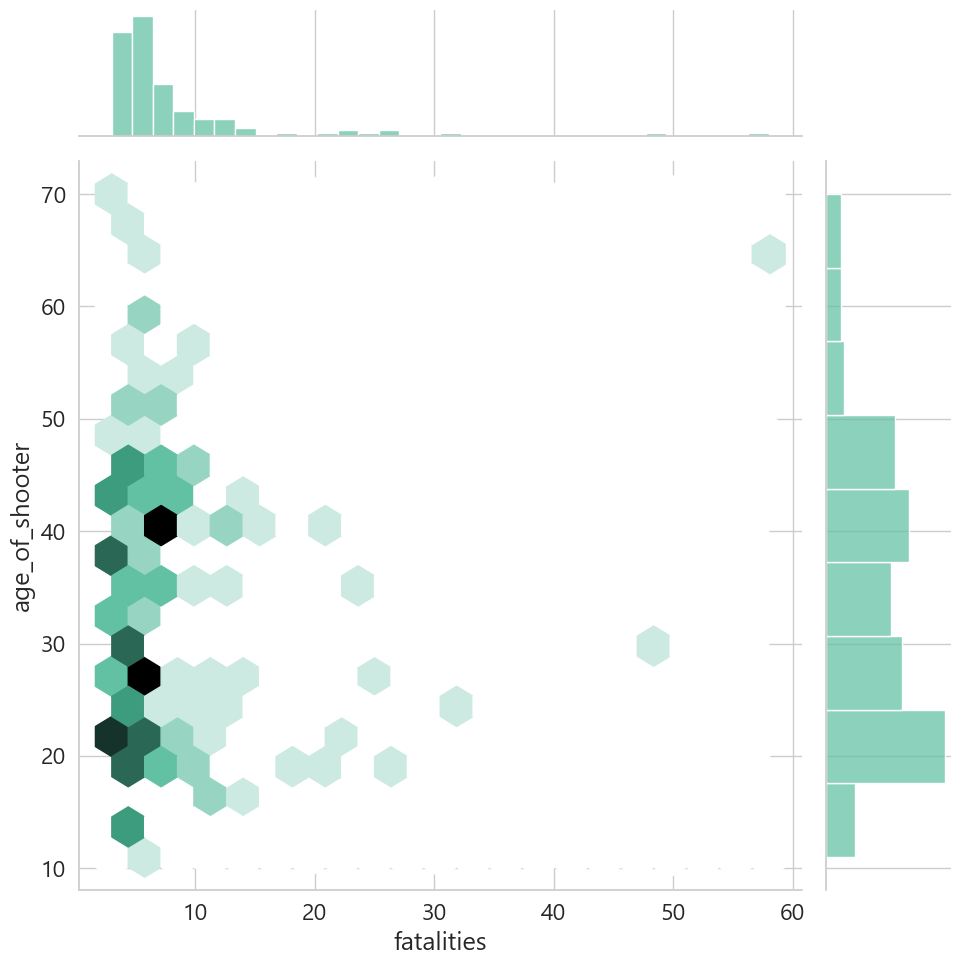

In [47]:
# 조인트 플로트를 이용한 연령대별 가해자와 사상자(부상자, 사상자 둘 중 하나)와 의 관계
# kind에 scatter를 하는 것보다 hex가 더 눈에 잘들어옴.
sns.jointplot(x = 'fatalities', y='age_of_shooter', kind='hex', height=10, data=df)


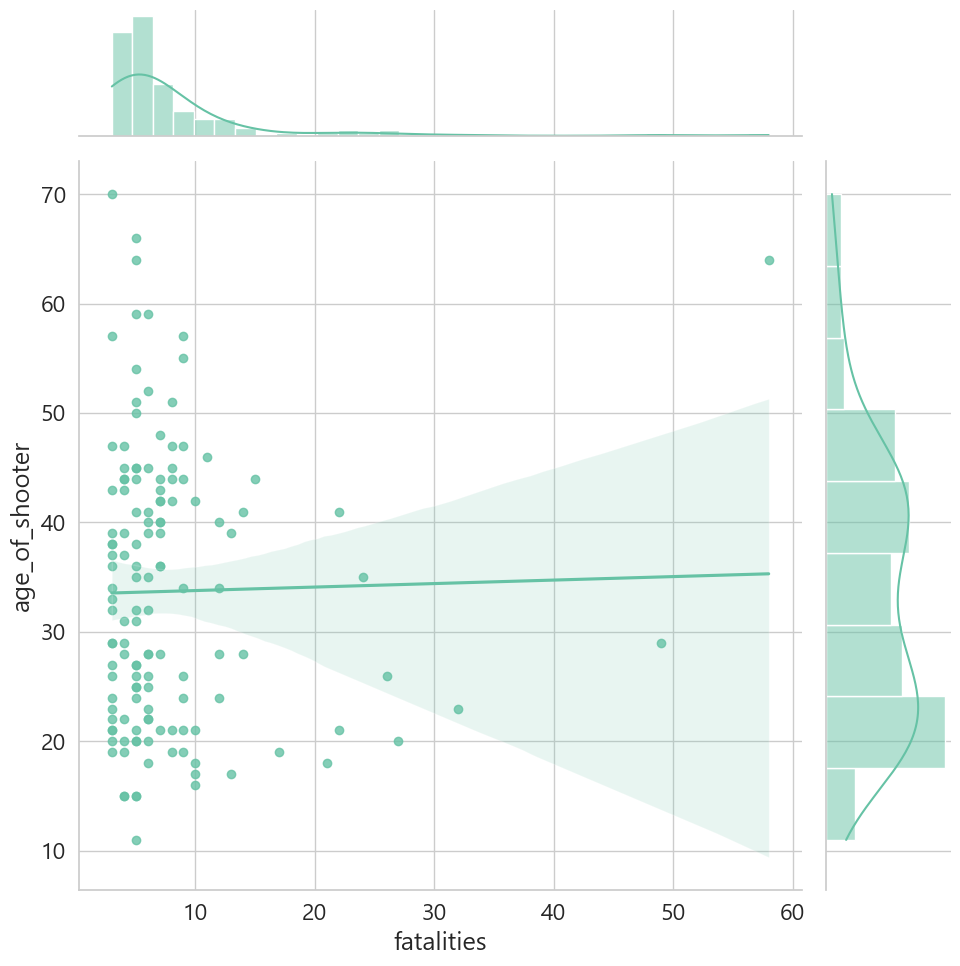

In [48]:
# 사망자 연령 통합 그래프
# 위의 시각화에서 kind만 reg로 변경
# 추정곡선을 그려준다. 뒤에 배경은 이렇게 될 수도 있다.라는 뜻
# 좁을 수록 좋다. 자세히 조사를 못함.

sns.jointplot(x='fatalities', y='age_of_shooter', kind='reg', height=10, data=df)

<Figure size 500x500 with 0 Axes>

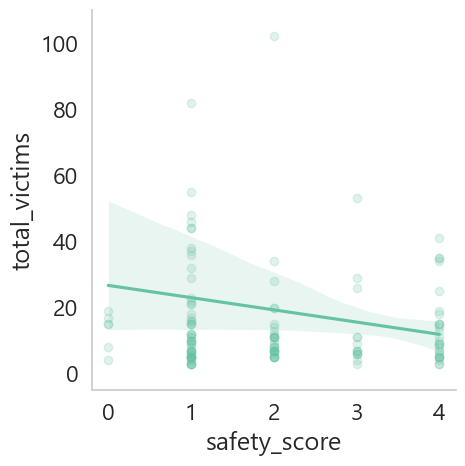

In [49]:
# 규제가 많이 적용 될 수록, 희생자 수가 줄어 든다.

# 안전점수 total_vitimes + 추세 
# 정리한 주의 안전점수와 기존 data 와의 연관성 확인하기
# 안전점수와 사건의 연관성 확인
# 산점도 : 두 변수의 상관관계, 상관분석과 관련
# 상관분석 :직선관계 분석, -1 ≤ r ≤ 1
# 총 희생자가 600명이 넘는 한 건의 사건으로 인해 산점도 분포와 상관분석이 제대로 보이지 않음
# y축 범위를 지정하여 상세그래프 보기 (아래의 이상치 사건 제외한 y축 범위로 지정)

plt.figure(figsize=(5,5))
sns.lmplot(x='safety_score', y='total_victims', data=data_safety_merge, fit_reg=True, scatter_kws={'alpha':0.2})
plt.ylim(-5, 110)
plt.grid()
# sns.regplot(x='safety_score', y='total_victims', data=dropData, fit_reg=True)

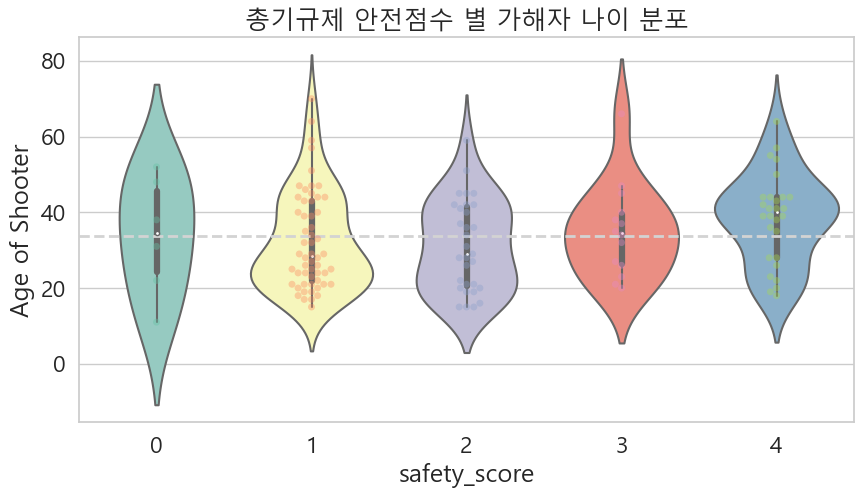

In [50]:
# 총기규제 안전점수별 가해자 연령 분포를 세분화 하여 시각화
# 규제가 많아지는 곳 일 수록 저연령층의 분포가 낮아진다.
# 총기규제 점수가 낮을수록 평균연령보다 적은 가해자의 분포가 몰려있음
# 쉽게 총기에 접근할 수 있음을 예측
plt.figure(figsize=(10,5))
sns.violinplot(x='safety_score', y='age_of_shooter', data=data_safety_merge, palette='Set3')
sns.swarmplot(data = data_safety_merge,x = 'safety_score', y ='age_of_shooter', alpha=0.4)
plt.axhline(total_age_mean, color='lightgray', linestyle='--', linewidth=2)
plt.title('총기규제 안전점수 별 가해자 나이 분포')
plt.xlabel('safety_score')
plt.ylabel('Age of Shooter')
plt.show()

<AxesSubplot:xlabel='age_group', ylabel='numweapons'>

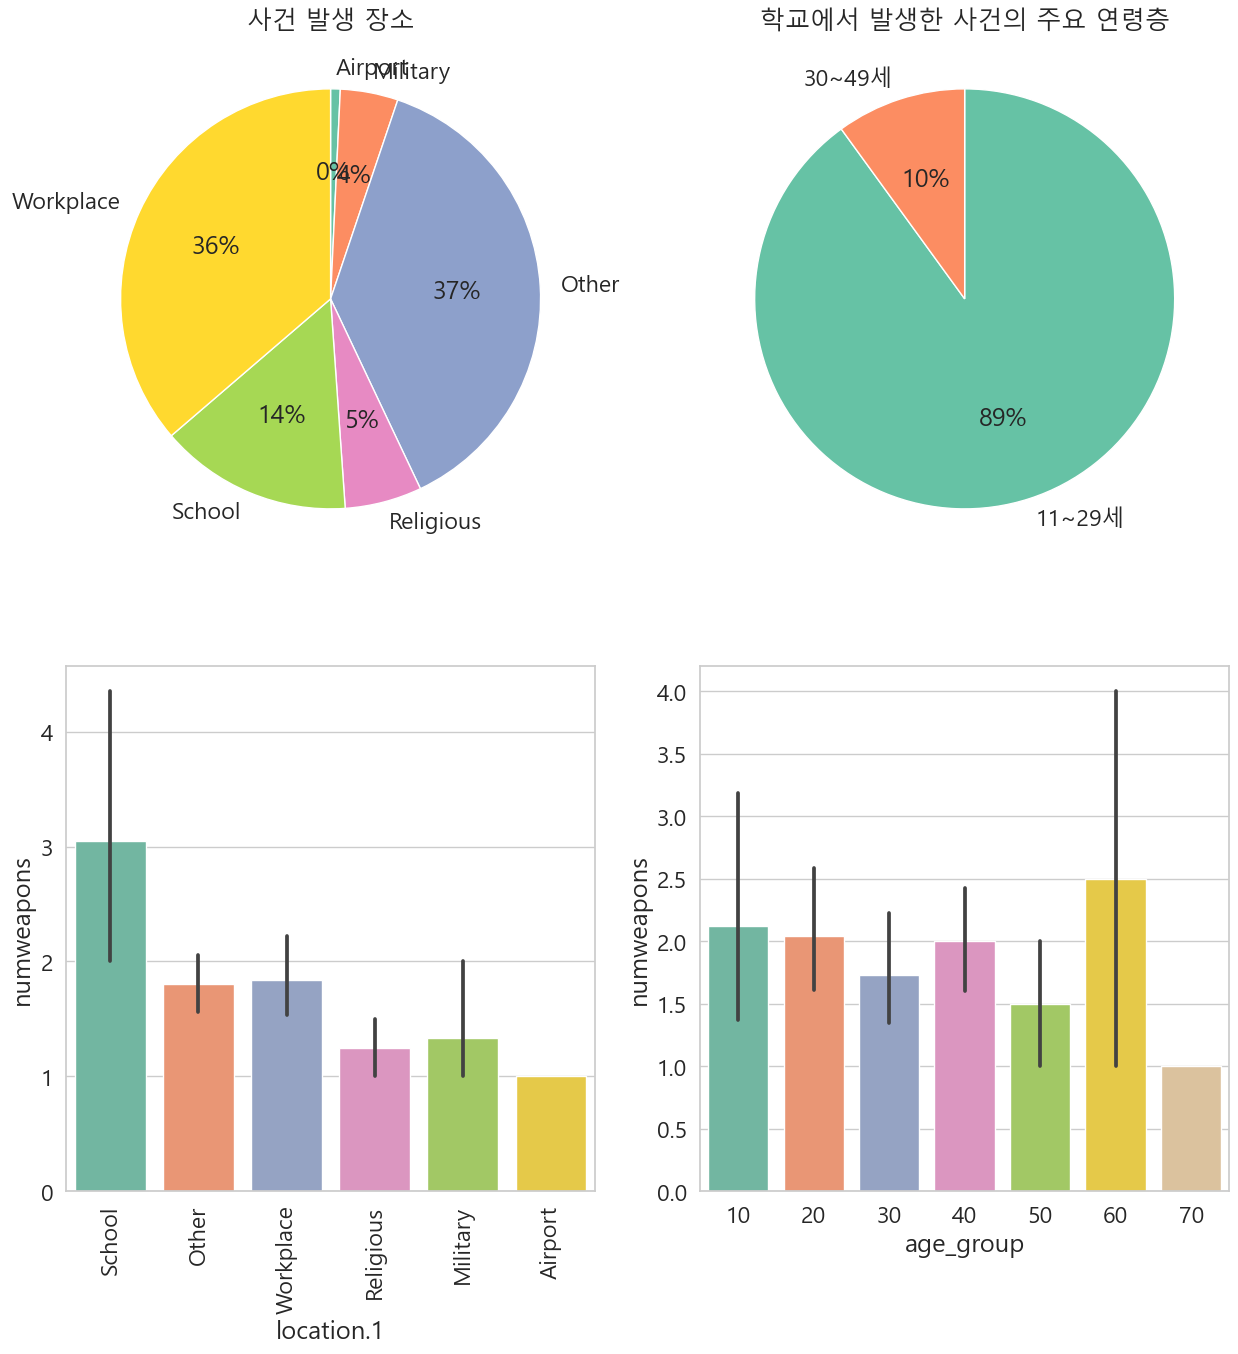

In [51]:
# 총격 사건 어떻게 줄일 수 있을까?
# 학교 범행의 사용 총기가 유독 많다
# 학교 범행의 용의자는 거의 '11~29세'이다.
# 하지만 전체 사건의 '11~29세' 사용 총기는 다른 연령대와 비슷하다.
# 따라서 학교 범행의 '11~29세' 용의자는 많은 총기를 사용하는 경향이 있다.

# 사건 발생 장소

df3= pd.read_csv('data/df3.csv')

df3.loc[df3['age_group']== 10 ,'age_group_2'] = '11~29세'
df3.loc[df3['age_group']== 20 ,'age_group_2'] = '11~29세'
df3.loc[df3['age_group']== 30 ,'age_group_2'] = '30~49세'
df3.loc[df3['age_group']== 40 ,'age_group_2'] = '30~49세'
df3.loc[df3['age_group']== 50 ,'age_group_2'] = '50~69세'
df3.loc[df3['age_group']== 60 ,'age_group_2'] = '50~69세'
df3.loc[df3['age_group']== 70 ,'age_group_2'] = '70세 이상'


# 사건 발생 장소
fig = plt.figure(figsize=(15,15))
a1 = fig.add_subplot(2,2,1)
data=df3.groupby(['location.1'])['case'].count()
plt.pie(data, labels=data.index , autopct='%d%%',startangle=90,counterclock=False)
a1.set_title('사건 발생 장소')

#학교에서 발생 건의 주요 용의자의 연령층
a2 = fig.add_subplot(2,2,2)
datadf3 = df3[df3['location.1']=='School']
data = datadf3.groupby(['age_group_2'])['case'].count()
plt.pie(data, labels=data.index , autopct='%d%%',startangle=90,counterclock=False)
a2.set_title('학교에서 발생한 사건의 주요 연령층')

#장소별 사건 발생 시 사용총기 갯수
a3 = fig.add_subplot(2,2,3)
#예외적인 값 정리 (numweapons = 24)
datadf3=df3.drop(index=44)
sns.barplot(x='location.1',y='numweapons',data=datadf3)
plt.xticks(rotation=90)
a2.set_title('학교에서 발생한 사건의 주요 연령층')

#연령별 사용 총기 갯수
a4 = fig.add_subplot(2,2,4)
datadf3=df3.drop(index=44)
sns.barplot(x='age_group',y='numweapons',data=datadf3)

C:\Users\user\AppData\Local\Temp\ipykernel_11512\2492262876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadf3.loc[datadf3['numweapons']==1,'weaponnum_group'] = '1정'
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword

Text(0.5, 0, '사건 장소')

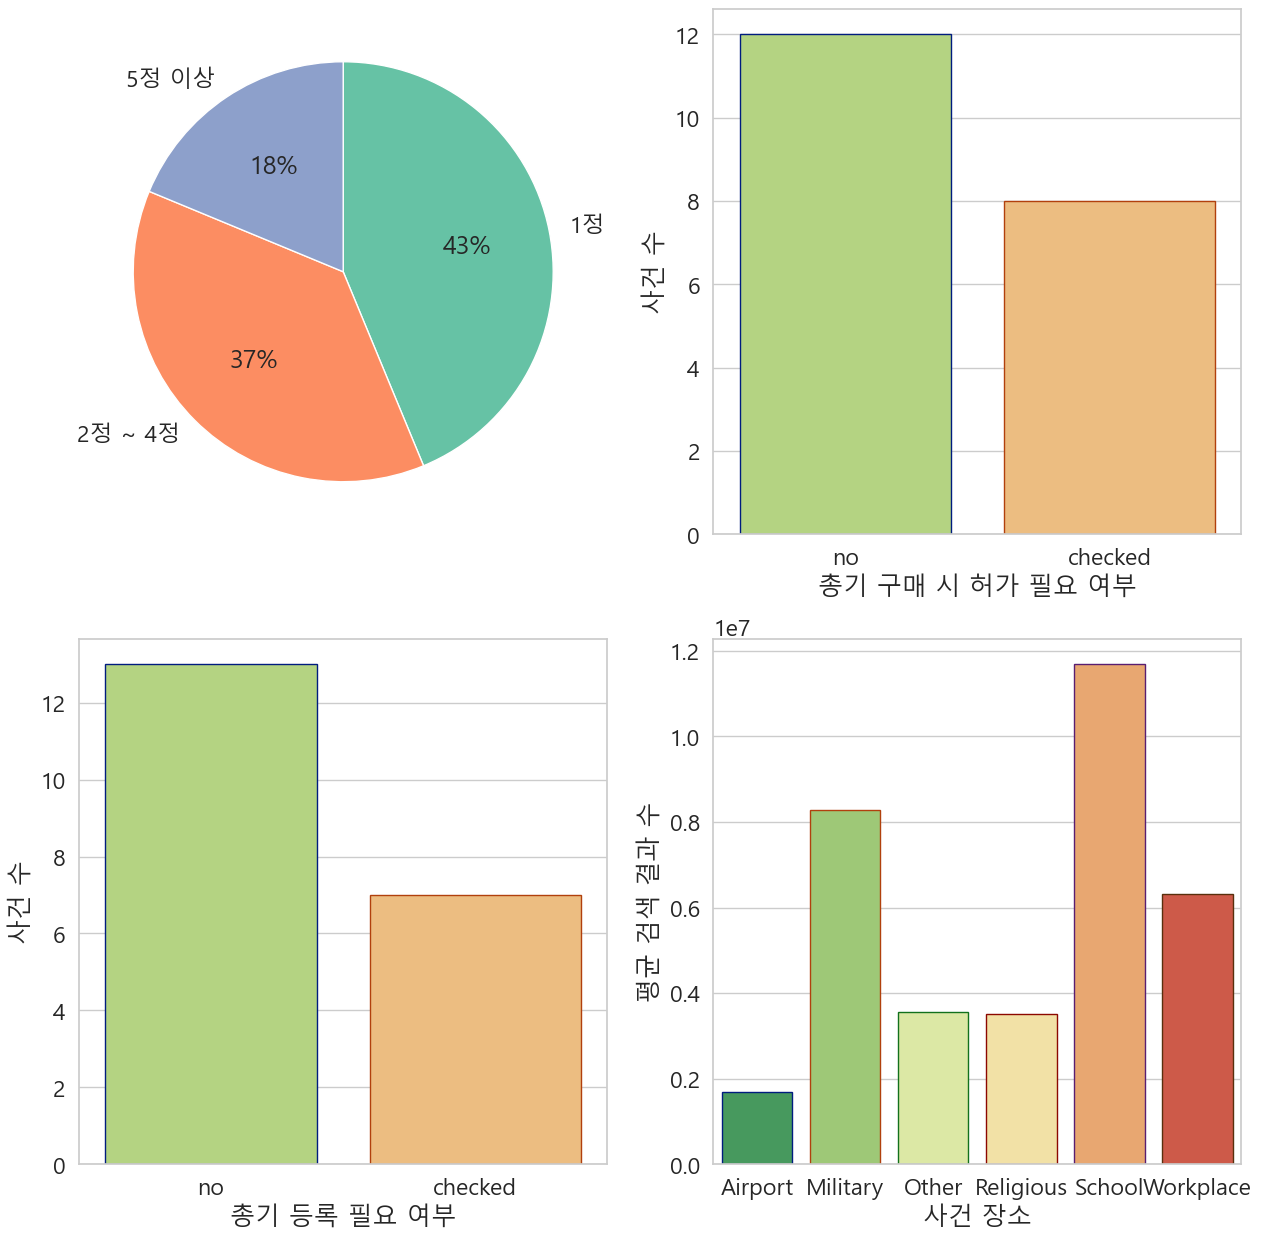

In [52]:
# 학교 사건의 경우, 학생의 총기 보유 여부를 확인해 두는 것이 더욱 효과적이다.
# 하지만 총기 보유 여부를 확인 가능케 할 규제가 충분하다고 보여지진 않는다.
# 그나마 다행인것은 학교 사건의 경우 충분한 관심을 받고 있다는 것이다.


fig = plt.figure(figsize=(15,15))


# 사용 총기 대수 별 사건 발생 수
a1 = fig.add_subplot(2,2,1)
datadf3 = df3[df3['location.1']=='School']
datadf3.loc[datadf3['numweapons']==1,'weaponnum_group'] = '1정'
datadf3.loc[datadf3['numweapons']>2,'weaponnum_group'] = '2정 ~ 4정'
datadf3.loc[datadf3['numweapons']>4,'weaponnum_group'] = '5정 이상'

data=datadf3.groupby(['weaponnum_group'])['case'].count()
plt.pie(data, labels=data.index , autopct='%d%%',startangle=90,counterclock=False)


#총기 구매 시 허가 필요 여부
a2 = fig.add_subplot(2,2,2)
datadf3 = df3[df3['location.1']=='School']
sns.countplot('permitReqToPurchase', data=datadf3, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
a2.set_ylabel('사건 수')
a2.set_xlabel('총기 구매 시 허가 필요 여부')


# 총기 등록 필요
a3 = fig.add_subplot(2,2,3)
datadf3 = df3[df3['location.1']=='School']
sns.countplot('firearmRegRequired', data=datadf3, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
a3.set_ylabel('사건 수')
a3.set_xlabel('총기 등록 필요 여부')


# 장소별 검색결과 수 / 장소별 사건 수
a4 = fig.add_subplot(2,2,4)

# index= 32,  numsearchresult 값에 오류가 있습니다. (케이스 명에 & 가 들어가, 오류 발생)
datadf3 = df3.drop(index=32)

data= datadf3.groupby(['location.1'])['numsearchresult'].sum()
data_n= datadf3.groupby(['location.1'])['case'].count()

for i in data.index :
    data[i] = data[i]/data_n[i]
sns.barplot(x=data.index, y=data ,palette='RdYlGn_r', edgecolor=sns.color_palette('dark',7))
a4.set_ylabel('평균 검색 결과 수')
a4.set_xlabel('사건 장소')

# sns.barplot(x='type', y='total_victims', hue='prior_signs_mental_health_issues', data=df);

# #연령별 평균 사용 무기 수
# # 예외적인 값 제거, numweapons = 24
# datadf3=df3.drop(index=44)
# plt.figure(figsize=(15,10))
# sns.barplot(x='age_group',y='numweapons',data=datadf3)


C:\Users\user\AppData\Local\Temp\ipykernel_11512\2492262876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datadf3.loc[datadf3['numweapons']==1,'weaponnum_group'] = '1정'
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword

Text(0.5, 0, '사건 장소')

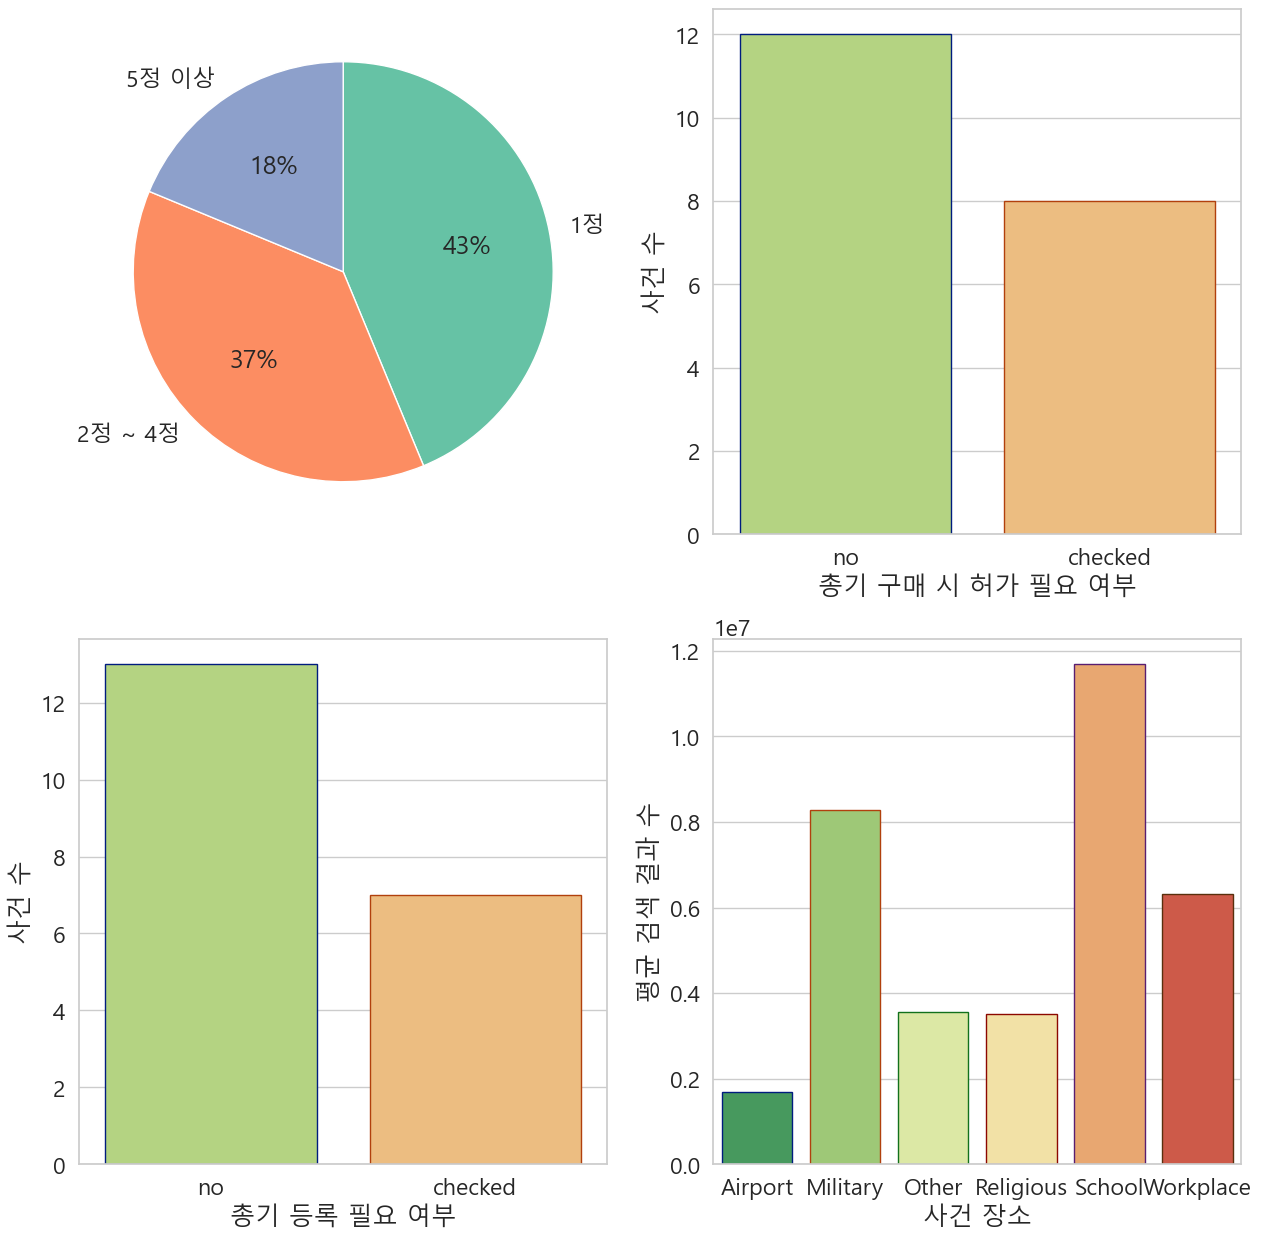

In [53]:
# 학교 사건의 경우, 학생의 총기 보유 여부를 확인해 두는 것이 더욱 효과적이다.
# 하지만 총기 보유 여부를 확인 가능케 할 규제가 충분하다고 보여지진 않는다.
# 그나마 다행인것은 학교 사건의 경우 충분한 관심을 받고 있다는 것이다.


fig = plt.figure(figsize=(15,15))


# 사용 총기 대수 별 사건 발생 수
a1 = fig.add_subplot(2,2,1)
datadf3 = df3[df3['location.1']=='School']
datadf3.loc[datadf3['numweapons']==1,'weaponnum_group'] = '1정'
datadf3.loc[datadf3['numweapons']>2,'weaponnum_group'] = '2정 ~ 4정'
datadf3.loc[datadf3['numweapons']>4,'weaponnum_group'] = '5정 이상'

data=datadf3.groupby(['weaponnum_group'])['case'].count()
plt.pie(data, labels=data.index , autopct='%d%%',startangle=90,counterclock=False)


#총기 구매 시 허가 필요 여부
a2 = fig.add_subplot(2,2,2)
datadf3 = df3[df3['location.1']=='School']
sns.countplot('permitReqToPurchase', data=datadf3, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
a2.set_ylabel('사건 수')
a2.set_xlabel('총기 구매 시 허가 필요 여부')


# 총기 등록 필요
a3 = fig.add_subplot(2,2,3)
datadf3 = df3[df3['location.1']=='School']
sns.countplot('firearmRegRequired', data=datadf3, palette='RdYlGn_r', 
              edgecolor=sns.color_palette('dark',7))
a3.set_ylabel('사건 수')
a3.set_xlabel('총기 등록 필요 여부')


# 장소별 검색결과 수 / 장소별 사건 수
a4 = fig.add_subplot(2,2,4)

# index= 32,  numsearchresult 값에 오류가 있습니다. (케이스 명에 & 가 들어가, 오류 발생)
datadf3 = df3.drop(index=32)

data= datadf3.groupby(['location.1'])['numsearchresult'].sum()
data_n= datadf3.groupby(['location.1'])['case'].count()

for i in data.index :
    data[i] = data[i]/data_n[i]
sns.barplot(x=data.index, y=data ,palette='RdYlGn_r', edgecolor=sns.color_palette('dark',7))
a4.set_ylabel('평균 검색 결과 수')
a4.set_xlabel('사건 장소')

# sns.barplot(x='type', y='total_victims', hue='prior_signs_mental_health_issues', data=df);

# #연령별 평균 사용 무기 수
# # 예외적인 값 제거, numweapons = 24
# datadf3=df3.drop(index=44)
# plt.figure(figsize=(15,10))
# sns.barplot(x='age_group',y='numweapons',data=datadf3)
